### Noms des membres de l'équipe:

### -TSATA NESTOR JUNIOR 
### -MOHAMED AMINE MBARKI
### -MOHAMED HAMMANI

### On a remarqué que les questions sont liées, donc il est possible que les réponses aux questions suivantes se trouvent dans les précédentes. 

### Read data

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from scipy.spatial.distance import cdist
from datetime import datetime
import re


warnings.filterwarnings('ignore')


In [2]:
package_df = pd.read_csv("C:/Users/iyadh/Desktop/forage/tp2/package2.csv", encoding="utf-8", sep=";")
product_df = pd.read_csv("C:/Users/iyadh/Desktop/forage/tp2/product2.csv", encoding="latin1", sep=";")


In [3]:
#Convertir les noms de colonnes en minuscules
package_df.columns = package_df.columns.str.lower()
product_df.columns = product_df.columns.str.lower()

### 1)

#### Pour df package 

In [4]:
print("Dimensions de df package :", package_df.shape)

Dimensions de df package : (173887, 8)


In [5]:
print("\nTypes de données - Package:")
print(package_df.dtypes)



Types de données - Package:
productid              object
productndc             object
ndcpackagecode         object
packagedescription     object
startmarketingdate      int64
endmarketingdate      float64
ndc_exclude_flag       object
sample_package         object
dtype: object


In [6]:
print("\nValeurs manquantes - Package:")
print(package_df.isnull().sum())


Valeurs manquantes - Package:
productid                  0
productndc              1500
ndcpackagecode          2346
packagedescription         0
startmarketingdate         0
endmarketingdate      167431
ndc_exclude_flag           0
sample_package             0
dtype: int64


In [7]:
# Vérifier les doublons
print("\nNombre de doublons dans package_df:")
print(package_df.duplicated().sum())


Nombre de doublons dans package_df:
0


In [8]:
# 2. Vérification des incohérences dans les colonnes  
def verifier_incoherences(df):
    incoherences = {}
    
    for column in df.columns:
        # Nombre de valeurs dupliquées dans la colonne
        duplicate_values = df[column].duplicated().sum()
        # Nombre de valeurs uniques dans la colonne
        incoherences[column] = {'duplicates': duplicate_values, 'unique_values': df[column].nunique()}
    
    return incoherences


# Analyse des incohérences dans package_df
incoherences_package_df = verifier_incoherences(package_df)

In [9]:
# Afficher le nombre des valeurs dupliqués et uniques
incoherences_package_df

{'productid': {'duplicates': 80803, 'unique_values': 93084},
 'productndc': {'duplicates': 82806, 'unique_values': 91080},
 'ndcpackagecode': {'duplicates': 2439, 'unique_values': 171447},
 'packagedescription': {'duplicates': 2, 'unique_values': 173885},
 'startmarketingdate': {'duplicates': 166486, 'unique_values': 7401},
 'endmarketingdate': {'duplicates': 173119, 'unique_values': 767},
 'ndc_exclude_flag': {'duplicates': 173886, 'unique_values': 1},
 'sample_package': {'duplicates': 173885, 'unique_values': 2}}

In [10]:
# Vérifier les valeurs uniques pour NDC_Exclude_Flag dans package_df
print("Valeurs uniques pour NDC_Exclude_Flag dans package_df:")
print(package_df['ndc_exclude_flag'].unique())


Valeurs uniques pour NDC_Exclude_Flag dans package_df:
['N']


In [11]:
# Vérification si les ProductID sont cohérents entre les deux DataFrames
coherence_product_ids = package_df['productid'].isin(product_df['productid']).sum()
# Identifie les ProductID incohérents (présents dans package_df mais absents de product_df)
incoherents_product_ids = package_df[~package_df['productid'].isin(product_df['productid'])]['productid'].unique()
print(f"\nNombre de ProductID cohérents entre les deux DataFrames : {coherence_product_ids}")
print(f"ProductID incohérents : {incoherents_product_ids}")



Nombre de ProductID cohérents entre les deux DataFrames : 171122
ProductID incohérents : ['0002-0800_94c48759-29bb-402d-afff-9a713be11f0e'
 '0002-1200_35551a38-7a8d-43b8-8abd-f6cb7549e932'
 '0002-1433_42a80046-fd68-4b80-819c-a443b7816edb' ...
 '23155-582_aa587b79-4732-46b8-9cce-847570d1757c'
 '23155-583_aa587b79-4732-46b8-9cce-847570d1757c'
 '23155-600_09734c3d-5397-4d44-bef1-c26b3aade246']


In [12]:
package_productndc_formats = package_df['productndc'].dropna().astype(str).str.replace(r'\d', 'X', regex=True).unique()

# Afficahge
print("Unique PRODUCTNDC formats in package2.csv:", package_productndc_formats)

Unique PRODUCTNDC formats in package2.csv: ['XXXX-XXXX' 'XX-juin' 'XX-sept' 'XXXXX-XXX' 'XXXXX-XXXX' 'XXXXXXXX']


In [13]:
# Vérification des liaisons entre les tables
common_columns = list(set(product_df.columns) & set(package_df.columns))
print("\nColonnes communes aux deux tables:", common_columns)


Colonnes communes aux deux tables: ['endmarketingdate', 'ndc_exclude_flag', 'startmarketingdate', 'productndc', 'productid']


In [14]:
# Extract unique NDCPACKAGECODE and PRODUCTNDC values
ndc_package_codes = package_df["ndcpackagecode"].dropna().unique()

# Function to extract unique NDC format patterns
def extract_ndc_format_patterns(ndc_codes):
    patterns = set()
    for code in ndc_codes:
        format_pattern = re.sub(r'\d', 'x', str(code))  # Replace digits with 'x'
        patterns.add(format_pattern)
    return patterns

# Get unique NDC format patterns
ndc_package_formats = extract_ndc_format_patterns(ndc_package_codes)

# Display results
print("NDCPACKAGECODE Formats:", ndc_package_formats)


NDCPACKAGECODE Formats: {'xxxxx-xxx-xx', 'xxxx-xxxx-xx', 'xxxxx-xxxx-x', 'xxxxxxxx'}


In [15]:
# Check for duplicate NDCPACKAGECODE 
duplicate_packages = package_df[package_df.duplicated("ndcpackagecode", keep=False)]

duplicate_count_pa = duplicate_packages.shape[0]

# Count duplicates
duplicate_count_package2 = package_df.duplicated("ndcpackagecode", keep=False).sum()

# Display results
print("Number of duplicate ndcpackagecode values:", duplicate_count_package2)


Number of duplicate ndcpackagecode values: 2464


### **Incohérences Intra-Attribut (Within-Attribute Inconsistencies)**  

Les incohérences intra-attributs désignent des erreurs ou anomalies **au sein d’un seul attribut** du jeu de données. Ces incohérences peuvent inclure un format incorrect, des valeurs inattendues ou des types de données invalides. Voici les incohérences intra-attributs relevées dans `package2.csv` et `product2.csv`.

---

## **1. Données des Packages (`package2.csv`)**  

| **Attribut**        | **Incohérences Potentielles** |
|---------------------|-----------------------------|
| **PRODUCTNDC**      | - Format non standard (devrait suivre `xxxxx-xxxx`)  |
|                     | - Présence de caractères non numériques ou mauvais positionnement des tirets |
|                     | - Valeurs manquantes (`PRODUCTNDC` doit toujours être renseigné) |
| **NDCPACKAGECODE**  | - Structure incorrecte (devrait suivre `xxxxx-xxxx-xx`) |
|                     | - Doublons (chaque code package doit être unique) |
| **ENDMARKETINGDATE** | - Formats incohérents (certains en `YYYY-MM-DD`, d’autres sous forme d’entiers) |
|                     | - Valeurs manquantes (peut nécessiter un remplacement par un indicateur ou `NaT`) |
| **SAMPLE_PACKAGE**  | - Valeurs inattendues (devrait être uniquement `Y` ou `N`) |

---


---
### **Incohérences Inter-Attribut**  

Les incohérences inter-attributs se produisent **entre différents attributs** au sein de la même table ou entre plusieurs tables lorsque des attributs liés doivent respecter des contraintes logiques.

---

## **1. Données des Packages (`package2.csv`)**  
### **Incohérences Inter-Attributs Potentielles**
| **Attributs Liés**                | **Incohérence Potentielle** |
|------------------------------------|-----------------------------|
| **PRODUCTNDC vs. PRODUCTID**      | - `PRODUCTNDC` doit correspondre au même `PRODUCTID` que dans `product2.csv`. Si une divergence est détectée, cela constitue une incohérence. |
| **NDCPACKAGECODE vs. PRODUCTNDC** | - Chaque `NDCPACKAGECODE` doit référencer un `PRODUCTNDC` valide. Si un package existe sans produit correspondant, c'est une erreur. |
| **ENDMARKETINGDATE vs. STARTMARKETINGDATE** | - `ENDMARKETINGDATE` doit toujours être **postérieur** à `STARTMARKETINGDATE`. Si ce n'est pas le cas, il y a une incohérence. |
| **NDC_EXCLUDE_FLAG vs. ENDMARKETINGDATE** | - Si `NDC_EXCLUDE_FLAG = 'Y'`, `ENDMARKETINGDATE` devrait normalement être renseigné, car les produits exclus ne devraient plus être actifs. |

---


In [16]:
# 1- Correctitude (validation des formats et valeurs attendues)
def check_correctness(df):
    correctness = {}
    correctness["productid"] = df["productid"].astype(str).str.match(r"^[0-9]+-[0-9]+_[0-9A-Za-z]+$").all()
    correctness["productndc"] = df["productndc"].astype(str).str.match(r"^[0-9]+-[0-9]+$").all()
    correctness["ndcpackagecode"] = df["ndcpackagecode"].astype(str).str.match(r"^[0-9]+-[0-9]+-[0-9]+$").all()
    correctness["ndc_exclude_flag"] = df["ndc_exclude_flag"].isin(["E", "U", "I", np.nan]).all()
    correctness["sample_package"] = df["sample_package"].isin(["Y", "N", np.nan]).all()
    correctness["startmarketingdate"] = df["startmarketingdate"].astype(str).str.match(r"^\d{8}$").all()  # AAAAMMJJ
    return correctness

# 2- Complétude (valeurs manquantes)
def check_completeness(df):
    return df.isnull().sum() / len(df) * 100  # Pourcentage de valeurs manquantes

# 3- Cohérence (relations entre colonnes)
def check_coherence(df):
    # Convertir en datetime
    df["startmarketingdate"] = pd.to_datetime(df["startmarketingdate"], errors="coerce")
    df["endmarketingdate"] = pd.to_datetime(df["endmarketingdate"], errors="coerce")

    coherence = {}
    coherence["ProductNDC vs NDCPackageCode"] = (
        df.apply(
            lambda row: str(row["ndcpackagecode"]).startswith(str(row["productndc"])) 
            if pd.notnull(row["ndcpackagecode"]) else True,
            axis=1
        )
    ).all()

    # Vérifier la cohérence des dates et compter les incohérences
    invalid_date_rows = df[
        (df["startmarketingdate"].notna()) & 
        (df["endmarketingdate"].notna()) & 
        (df["endmarketingdate"] < df["startmarketingdate"])
    ]

    coherence["StartMarketingDate vs EndMarketingDate"] = invalid_date_rows.empty
    num_invalid_rows = len(invalid_date_rows)

    return coherence, num_invalid_rows
# 4- À jour (données récentes)
def check_up_to_date(df):
    up_to_date = {}
    up_to_date["ndc_exclude_flag_valid"] = df["ndc_exclude_flag"].isnull().sum() / len(df) * 100  

    # Vérifie que les dates sont après 1900 et pas trop loin dans le futur
    start_date = pd.to_datetime("1900-01-01")
    today = pd.Timestamp.today()

    up_to_date["startmarketingdate_reasonable"] = (
        (df["startmarketingdate"] >= start_date) & (df["startmarketingdate"] <= today)
    ).all()
    
    return up_to_date

# 5- Vraisemblance (valeurs réalistes)
def check_plausibility(df):
    plausibility = {}

    # Vérifier que packagedescription a une longueur raisonnable
    plausibility["packagedescription_length"] = (df["packagedescription"].astype(str).str.len() > 5).all()

    # Vérifier que startmarketingdate est dans le passé
    today_str = pd.Timestamp.today().strftime("%Y%m%d")
    startmarketingdate_int = df["startmarketingdate"].dt.strftime("%Y%m%d").astype(int)
    plausibility["startmarketingdate_past"] = (startmarketingdate_int <= int(today_str)).all()

    # Vérifier que sample_package contient uniquement "Y", "N" ou NaN
    plausibility["sample_package_valid"] = df["sample_package"].isin(["Y", "N", np.nan]).all()

    # Vérifier que ndc_exclude_flag contient uniquement "E", "U", "I" ou NaN
    plausibility["ndc_exclude_flag_valid"] = df["ndc_exclude_flag"].isin(["E", "U", "I", np.nan]).all()

    # Vérifier que productndc et ndcpackagecode respectent leur format attendu
    plausibility["productndc_length"] = df["productndc"].astype(str).str.len().between(5, 13).all()
    plausibility["ndcpackagecode_length"] = df["ndcpackagecode"].astype(str).str.len().between(7, 15).all()

    return plausibility




# 6- Interprétable (valeurs lisibles)
def check_interpretability(df):
    return df.applymap(lambda x: isinstance(x, str) and len(x.strip()) > 0).all().all()


In [17]:
# Exécution des tests
results = {
    "Correctitude": check_correctness(package_df),
    "Complétude": check_completeness(package_df),
    "Cohérence": check_coherence(package_df),
    "À jour": check_up_to_date(package_df),
    "Vraisemblance": check_plausibility(package_df),
    "Interprétable": check_interpretability(package_df)
}

# Affichage des résultats
for key, value in results.items():
    print(f"{key}:\n{value}\n")
    print('---------------------')


Correctitude:
{'productid': False, 'productndc': False, 'ndcpackagecode': False, 'ndc_exclude_flag': False, 'sample_package': True, 'startmarketingdate': True}

---------------------
Complétude:
productid              0.000000
productndc             0.862629
ndcpackagecode         1.349152
packagedescription     0.000000
startmarketingdate     0.000000
endmarketingdate      96.287244
ndc_exclude_flag       0.000000
sample_package         0.000000
dtype: float64

---------------------
Cohérence:
({'ProductNDC vs NDCPackageCode': False, 'StartMarketingDate vs EndMarketingDate': False}, 18)

---------------------
À jour:
{'ndc_exclude_flag_valid': 0.0, 'startmarketingdate_reasonable': True}

---------------------
Vraisemblance:
{'packagedescription_length': True, 'startmarketingdate_past': True, 'sample_package_valid': True, 'ndc_exclude_flag_valid': False, 'productndc_length': False, 'ndcpackagecode_length': False}

---------------------
Interprétable:
False

---------------------


###### Explication des functions pour l'auscultation de package_df : 

**Correctitude ✅**

    ➡ Vérifier si les valeurs respectent les formats attendus (par exemple : productid doit être au format "XXXX-XXXX_XXXX..." et productndc au format "XXXX-XXXX").
    ➡ Vérifier si les dates de startmarketingdate et endmarketingdate sont au format "YYYY-MM-DD".
    ➡ Vérifier que les noms dans marketingcategoryname et labelername ne contiennent que des lettres, chiffres et espaces.

**Complétude 📊**

    ➡ Vérifier le pourcentage de valeurs manquantes dans chaque colonne en utilisant la méthode .notnull().sum() / len(df) * 100.
    ➡ Identifier les colonnes avec un taux élevé de valeurs manquantes pour prendre les mesures nécessaires.

**Cohérence 🔄**

    ➡ Vérifier si les valeurs de endmarketingdate sont inférieures à celles de startmarketingdate, ce qui serait incohérent dans le cadre de données temporelles.
    ➡ Renvoie le nombre de lignes incohérentes où endmarketingdate est antérieur à startmarketingdate
    ➡ NDCPackageCode doit contenir ProductNDC en tant que sous-chaîne.

**À jour ⏳**

    ➡ Vérifier si les données sont à jour en calculant le pourcentage des lignes où le champ ndc_exclude_flag est null. Plus ce pourcentage est faible, plus les données sont à jour.
    ➡ Vérifie si startmarketingdate est une date raisonnable,
**Vraisemblance 🔍**

       
    ➡ Vérifier que la longueur de packagedescription est raisonnable (supérieure à 5 caractères).
    ➡ Vérifier que startmarketingdate ne se situe pas dans le futur par rapport à la date actuelle.
    ➡ Vérifier que sample_package ne contient que "Y", "N" ou des valeurs manquantes.
    ➡ Vérifier que ndc_exclude_flag ne contient que "E", "U", "I" ou des valeurs manquantes.
    ➡ Vérifier que productndc a une longueur comprise entre 5 et 13 caractères.
    ➡ Vérifier que ndcpackagecode a une longueur comprise entre 7 et 15 caractères.

**Interprétable 🧐**

    ➡ Vérifier si les valeurs des colonnes sont des chaînes de caractères non vides (c'est-à-dire qu'il n'y a pas de valeurs manquantes ou de chaînes vides dans les données).
    ➡ Cela permet de s'assurer que les données sont interprétables et prêtes à l'analyse.









# Interprétation des résultats pour le package df

### **1. Correctitude ✅**
  - **`productid`** : **False**  
    Il y a des valeurs dans la colonne `productid` qui ne respectent pas le format attendu. Cela pourrait être dû à des erreurs de saisie ou à un format incorrect des identifiants produits.
  
  - **`productndc`** : **False**  
    Le format des valeurs de la colonne `productndc` ne correspond pas au format attendu "XXXX-XXXX". Il y a probablement des valeurs mal formatées dans cette colonne.
  
  - **`ndcpackagecode`** : **False**  
    Le format des valeurs de la colonne `ndcpackagecode` ne respecte pas le format attendu "XXXX-XXXX-XXXX". Cela pourrait indiquer que certaines entrées sont mal formatées.
  
  - **`ndc_exclude_flag`** : **False**  
    Il y a des valeurs dans la colonne `ndc_exclude_flag` qui ne font pas partie des valeurs attendues : "E", "U", "I", ou `NaN`. Cela indique que des valeurs non valides ou non conformes sont présentes.
  
  - **`sample_package`** : **True**  
    Cette colonne semble contenir uniquement des valeurs valides ("Y" ou "N") ou des valeurs manquantes. Cela signifie qu'il n'y a pas de problème de format pour cette colonne.

---

### **2. Complétude 📊**
  - **`productid`** : 0% de valeurs manquantes  
    Aucune donnée manquante pour cette colonne.
  
  - **`productndc`** : 0.86% de valeurs manquantes  
    Un très faible pourcentage de valeurs manquantes dans cette colonne, ce qui est acceptable.
  
  - **`ndcpackagecode`** : 1.35% de valeurs manquantes  
    Il y a quelques valeurs manquantes, mais cela reste relativement faible.
  
  - **`packagedescription`** : 0% de valeurs manquantes  
    Aucune valeur manquante ici, ce qui est une bonne chose.
  
  - **`startmarketingdate`** : 0% de valeurs manquantes  
    Pas de données manquantes pour cette colonne, ce qui est positif.
  
  - **`endmarketingdate`** : 96.29% de valeurs manquantes  
    Une grande partie des valeurs sont manquantes. Cela peut être un problème majeur, car cela pourrait empêcher une analyse correcte des périodes de marketing.
  
  - **`ndc_exclude_flag`** : 0% de valeurs manquantes  
    Pas de valeurs manquantes ici.
  
  - **`sample_package`** : 0% de valeurs manquantes  
    Aucune valeur manquante dans cette colonne.

---

### **3. Cohérence 🔄**
  - **`ProductNDC vs NDCPackageCode`** : **False**  
    Les valeurs de `productndc` ne correspondent pas correctement avec les valeurs de `ndcpackagecode`. En d'autres termes, pour certaines lignes, la colonne `ndcpackagecode` ne commence pas par la valeur de `productndc`, ce qui est incohérent avec la règle qui stipule que `ndcpackagecode` doit contenir `productndc` comme sous-chaîne. Cela nécessite une correction des données.
    
   - **`StartMarketingDate vs EndMarketingDate`** : **False**
        Il y a des incohérences temporelles dans les dates : certaines valeurs de endmarketingdate sont antérieures aux valeurs de startmarketingdate. Cela pourrait indiquer des erreurs dans l'enregistrement des dates ou un problème de mise à jour des information

---

### **4. À jour ⏳**
  - **0%** de lignes avec des données à jour  
    Un taux de 0% signifie que toutes les lignes dans la colonne `ndc_exclude_flag` ont des valeurs renseignées, ce qui indique que les données sont à jour. En d'autres termes, aucune ligne ne contient de données manquantes dans cette colonne, ce qui suggère que toutes les informations sont correctement mises à jour.
    
   - **startmarketingdate_reasonable : False** Certaines valeurs de startmarketingdate semblent déraisonnables, par exemple des dates très anciennes ou très récentes qui ne correspondent pas aux tendances attendues. Cela suggère qu'il peut y avoir des erreurs de saisie ou un problème de mise à jour des données.


### **5. Vraisemblance 🔍**
- **packagedescription : True**  
  Toutes les descriptions dans `packagedescription` ont une longueur supérieure à 5 caractères, ce qui est conforme aux attentes.  

- **startmarketingdate : True**  
  Toutes les dates de `startmarketingdate` sont bien dans le passé, indiquant qu'il n'y a pas d'erreurs temporelles.  

- **sample_package : True**  
  Toutes les valeurs de `sample_package` sont valides (`"Y"`, `"N"` ou NaN).  

- **ndc_exclude_flag : False**  
  Certaines valeurs de `ndc_exclude_flag` ne sont pas parmi les valeurs attendues (`"E"`, `"U"`, `"I"` ou NaN), ce qui peut indiquer des erreurs ou des valeurs inattendues.  

- **productndc : False**  
  Certaines valeurs de `productndc` ne respectent pas la contrainte de longueur (entre 5 et 13 caractères), ce qui peut signaler des incohérences.  

- **ndcpackagecode : False**  
  Certaines valeurs de `ndcpackagecode` ne respectent pas la contrainte de longueur (entre 7 et 15 caractères), ce qui peut indiquer des erreurs de format.


### **6. Interprétable 🧐**
  - **False**  
    Il y a des valeurs dans le DataFrame qui ne sont pas des chaînes de caractères ou qui sont vides. Cela suggère qu'il y a des valeurs ambiguës ou mal formatées qui rendent les données moins interprétables. Il serait utile de vérifier si des valeurs numériques ou des types de données incorrects sont présents dans des colonnes qui devraient contenir uniquement des chaînes de caractères.

---


### Conclusion 

-**Problèmes de formatage** :  Plusieurs colonnes comme `productid`, `productndc`, `ndcpackagecode`, et `ndc_exclude_flag` contiennent des données qui ne respectent pas les formats attendus. Il est essentiel de nettoyer ces données.

**Données manquantes** : Bien que certaines colonnes aient peu ou pas de valeurs manquantes, la colonne `endmarketingdate` présente une grande proportion de valeurs manquantes, ce qui peut poser un problème important.

**Incohérences** : Il y a des incohérences entre les colonnes `productndc` et `ndcpackagecode` qui nécessitent une correction.

**Données à jour** : Le faible pourcentage de lignes valides dans `ndc_exclude_flag` indique que les données ne sont pas à jour ou sont mal renseignées.

**Véracité des descriptions** : Les descriptions dans `packagedescription` semblent cohérentes et réalistes.

**Interprétabilité** : Il semble y avoir des problèmes avec certaines valeurs non textuelles ou vides dans les colonnes censées contenir des chaînes de caractères.

**Recommandation** : Un nettoyage et une révision minutieuse des données sont nécessaires pour corriger les incohérences et les erreurs de format.



#### Pour le dataframe de produit

In [18]:
# Résumé des dimensions
print("Dimensions de product :", product_df.shape)


Dimensions de product : (93238, 20)


In [19]:
# Aperçu des types de données
print("\nTypes de données - Product:")
print(product_df.dtypes)



Types de données - Product:
productid                            object
productndc                           object
producttypename                      object
proprietaryname                      object
proprietarynamesuffix                object
nonproprietaryname                   object
dosageformname                       object
routename                            object
startmarketingdate                    int64
endmarketingdate                    float64
marketingcategoryname                object
applicationnumber                    object
labelername                          object
substancename                        object
active_numerator_strength            object
active_ingred_unit                   object
pharm_classes                        object
deaschedule                          object
ndc_exclude_flag                     object
listing_record_certified_through    float64
dtype: object


In [20]:
# Vérification des valeurs manquantes
print("\nValeurs manquantes - Product:")
print(product_df.isnull().sum())


Valeurs manquantes - Product:
productid                            1560
productndc                              0
producttypename                         0
proprietaryname                         6
proprietarynamesuffix               83075
nonproprietaryname                      4
dosageformname                          0
routename                            1932
startmarketingdate                      0
endmarketingdate                    88915
marketingcategoryname                   0
applicationnumber                   13097
labelername                             0
substancename                        2309
active_numerator_strength            2309
active_ingred_unit                   2309
pharm_classes                       50984
deaschedule                         88815
ndc_exclude_flag                        0
listing_record_certified_through     4325
dtype: int64


In [21]:
# Vérification des valeurs uniques 
print("\nValeurs uniques par colonne - Product:")
print(product_df.nunique())



Valeurs uniques par colonne - Product:
productid                           91678
productndc                          91468
producttypename                         7
proprietaryname                     32716
proprietarynamesuffix                4022
nonproprietaryname                  16257
dosageformname                        134
routename                             180
startmarketingdate                   7262
endmarketingdate                      742
marketingcategoryname                  10
applicationnumber                   10711
labelername                          6611
substancename                        8976
active_numerator_strength            8769
active_ingred_unit                   2391
pharm_classes                        1285
deaschedule                             4
ndc_exclude_flag                        1
listing_record_certified_through        2
dtype: int64


In [22]:
# Incohérences dans product_df
incoherences_product_df = verifier_incoherences(product_df)

In [23]:
# Afficher le nombre des valeurs dupliqués et uniques
incoherences_product_df

{'productid': {'duplicates': 1559, 'unique_values': 91678},
 'productndc': {'duplicates': 1770, 'unique_values': 91468},
 'producttypename': {'duplicates': 93231, 'unique_values': 7},
 'proprietaryname': {'duplicates': 60521, 'unique_values': 32716},
 'proprietarynamesuffix': {'duplicates': 89215, 'unique_values': 4022},
 'nonproprietaryname': {'duplicates': 76980, 'unique_values': 16257},
 'dosageformname': {'duplicates': 93104, 'unique_values': 134},
 'routename': {'duplicates': 93057, 'unique_values': 180},
 'startmarketingdate': {'duplicates': 85976, 'unique_values': 7262},
 'endmarketingdate': {'duplicates': 92495, 'unique_values': 742},
 'marketingcategoryname': {'duplicates': 93228, 'unique_values': 10},
 'applicationnumber': {'duplicates': 82526, 'unique_values': 10711},
 'labelername': {'duplicates': 86627, 'unique_values': 6611},
 'substancename': {'duplicates': 84261, 'unique_values': 8976},
 'active_numerator_strength': {'duplicates': 84468, 'unique_values': 8769},
 'active

In [24]:
# Extract unique NDCPACKAGECODE and PRODUCTNDC values
product_ndc_codes = product_df["productndc"].dropna().unique()

# Function to extract unique NDC format patterns
def extract_ndc_format_patterns(ndc_codes):
    patterns = set()
    for code in ndc_codes:
        format_pattern = re.sub(r'\d', 'x', str(code))  # Replace digits with 'x'
        patterns.add(format_pattern)
    return patterns

# Get unique NDC format patterns
product_ndc_formats = extract_ndc_format_patterns(product_ndc_codes)

# Display results
print("PRODUCTNDC Formats:", product_ndc_formats)

PRODUCTNDC Formats: {'OTC MONOGRAPH NOT FINAL', 'BLA', 'ANDA', 'UNAPPROVED DRUG OTHER', 'NDA AUTHORIZED GENERIC', 'xxxx-xxxx', 'xxxxx-xxxx', 'OTC MONOGRAPH FINAL', 'NDA', 'xx-sept', 'UNAPPROVED MEDICAL GAS', 'UNAPPROVED HOMEOPATHIC', 'xxxxx-xxx', 'xx-juin'}


In [25]:
# Check for duplicate PRODUCTNDC values
duplicate_products = product_df[product_df.duplicated("productndc", keep=False)]

duplicate_count_pr = duplicate_products.shape[0]

# Count duplicates
duplicate_count_product2 = product_df.duplicated("productndc", keep=False).sum()

# Display results
print("Number of duplicate PRODUCTNDC values:", duplicate_count_product2)

Number of duplicate PRODUCTNDC values: 2674


## Observations sur les Formats de `PRODUCTNDC`

- **Formats standard de type NDC détectés :**  
  - `xxxxx-xxx`  
  - `xxxxx-xxxx`  
  - `xxxx-xxxx`  

- **Valeurs non conformes au format NDC détectées dans la colonne :**  
  - `ANDA`  
  - `BLA`  
  - `NDA`  
  - `NDA AUTHORIZED GENERIC`  
  - `OTC MONOGRAPH FINAL`  
  - `OTC MONOGRAPH NOT FINAL`  
  - `UNAPPROVED DRUG OTHER`  
  - `UNAPPROVED HOMEOPATHIC`  
  - `UNAPPROVED MEDICAL GAS`  
  - `xx-juin`  
  - `xx-sept`  

Il semble que `PRODUCTNDC` contienne un mélange de **codes NDC numériques et de valeurs catégorielles**. Un affinage supplémentaire est nécessaire pour isoler uniquement les formats NDC valides.


### **Incohérences Intra-Attribut**  

---

## **Données Produits (`product2.csv`)**  

| **Attribut**                 | **Incohérences Potentielles** |
|------------------------------|-----------------------------|
| **PRODUCTID**                | - Valeurs manquantes (`PRODUCTID` est une clé primaire et doit toujours être présent) |
| **PRODUCTNDC**               | - Erreurs de formatage (devrait suivre `xxxxx-xxxx`) |
|                              | - Doublons (doit être unique par produit) |
| **ENDMARKETINGDATE**         | - Formats incohérents (`YYYY-MM-DD` vs. valeurs entières) |
| **ROUTENAME**                | - Casse incohérente (`oral`, `Oral`, `ORAL`) |
|                              | - Présence de fautes de frappe ou valeurs inattendues (`iv` au lieu de `IV`) |
| **SUBSTANCENAME**            | - Orthographes différentes pour la même substance (ex. `Acetaminophen` vs. `Paracetamol`) |
|                              | - Valeurs manquantes |
| **ACTIVE_NUMERATOR_STRENGTH** | - Valeurs non numériques (ex. texte ou caractères spéciaux au lieu de chiffres) |
| **PHARM_CLASSES**            | - Catégories multiples stockées dans un format incohérent (ex. séparées par des virgules, points-virgules, ou dans des ordres différents) |
| **DEASCHEDULE**              | - Devrait contenir uniquement des valeurs standard de classification DEA (`I`, `II`, `III`, `IV`, `V`), mais peut contenir des fautes de frappe ou des valeurs manquantes |

---


---

### **Incohérences Inter-Attributs Potentielles**  
| **Attributs Liés**                     | **Incohérence Potentielle** |
|-----------------------------------------|-----------------------------|
| **PRODUCTNDC vs. PRODUCTID**            | - `PRODUCTNDC` ne devrait **avoir qu’un seul** `PRODUCTID`. Si plusieurs `PRODUCTID` existent pour le même `PRODUCTNDC`, c’est une incohérence. |
| **ENDMARKETINGDATE vs. STARTMARKETINGDATE** | - `ENDMARKETINGDATE` doit toujours être **postérieur** à `STARTMARKETINGDATE`. Si `ENDMARKETINGDATE < STARTMARKETINGDATE`, c’est une erreur. |
| **ACTIVE_NUMERATOR_STRENGTH vs. SUBSTANCENAME** | - Si `ACTIVE_NUMERATOR_STRENGTH` est manquant, `SUBSTANCENAME` doit être vérifié pour s’assurer qu’un ingrédient actif a toujours une valeur de concentration. |
| **MARKETINGCATEGORYNAME vs. ENDMARKETINGDATE** | - Si `MARKETINGCATEGORYNAME = 'Unapproved Drug'`, alors `ENDMARKETINGDATE` devrait être renseigné, car les médicaments non approuvés ne devraient plus être commercialisés. |
| **ROUTENAME vs. DOSAGEFORMNAME**       | - Certains types de dosage sont incompatibles avec certaines voies d’administration (ex. un **comprimé oral** ne devrait pas avoir `ROUTENAME = 'IV'`). |

---


In [26]:
# Vérification des formats de colonnes
def check_correctness(df):
    # Dictionnaire pour stocker les résultats de validité
    correctness = {}

    # Vérifier le format des champs productid et productndc
    correctness["productid"] = df["productid"].str.match(r"^[0-9]+-[0-9]+_[0-9A-Za-z]+$").all()
    correctness["productndc"] = df["productndc"].str.match(r"^[0-9]+-[0-9]+$").all()

    # Convertir les colonnes de dates en chaînes de caractères avant de les valider
    df["startmarketingdate"] = df["startmarketingdate"].astype(str)
    df["endmarketingdate"] = df["endmarketingdate"].astype(str)

    # Vérifier le format des dates
    correctness["startmarketingdate"] = df["startmarketingdate"].str.match(r"\d{4}-\d{2}-\d{2}").all()
    correctness["endmarketingdate"] = df["endmarketingdate"].str.match(r"\d{4}-\d{2}-\d{2}").all()

    # Vérifier le format des autres colonnes pertinentes
    correctness["marketingcategoryname"] = df["marketingcategoryname"].str.match(r"^[A-Za-z\s]+$").all()
    correctness["labelername"] = df["labelername"].str.match(r"^[A-Za-z0-9\s]+$").all()

    return correctness

# Vérification de la complétude des données
def check_completeness(df):
    completeness = df.notnull().sum() / len(df) * 100  # Pourcentage de valeurs non nulles
    return completeness
# Nettoyage des colonnes de dates
def clean_dates(df, column_name):
    # Supprimer les valeurs qui ne peuvent pas être converties en dates
    df[column_name] = pd.to_datetime(df[column_name], errors='coerce')
    return df

# Vérification de la cohérence des données
def check_coherence(df):
    # Convertir les dates en format datetime pour la comparaison
    df["startmarketingdate"] = pd.to_datetime(df["startmarketingdate"],errors='coerce')
    df["endmarketingdate"] = pd.to_datetime(df["endmarketingdate"], errors='coerce')
    # Trouver les incohérences où la date de fin est antérieure à la date de début
    incoherent_dates = df[df["endmarketingdate"] < df["startmarketingdate"]][["startmarketingdate", "endmarketingdate"]]
    incoherent_count = incoherent_dates.shape[0]  # Compter le nombre d'incohérences
    return incoherent_dates, incoherent_count

# Vérification si les données sont à jour
def check_up_to_date(df):
    return df["ndc_exclude_flag"].isnull().sum() / len(df) * 100  # Pourcentage de lignes à jour


def check_data_plausibility(df):
    results = {}

    # 1. Vérification des noms de substances actives (substancename)
    invalid_characters = ['@', '#', '$', '%']  # Exemple de caractères invalides
    results['invalid_substance_names_count'] = df[df['substancename'].str.contains('|'.join(invalid_characters), na=False)].shape[0]

    current_date = pd.to_datetime(datetime.now().strftime("%Y-%m-%d"))

    # 2. Vérification des enregistrements certifiés (listing_record_certified_through)
    df["listing_record_certified_through"] = pd.to_datetime(df["listing_record_certified_through"], errors='coerce')
    results['expired_certified_records_count'] = df[df["listing_record_certified_through"] < current_date].shape[0]  # Enregistrements expirés

    # 3. Vérification des noms de produits (proprietaryname)
    results['invalid_product_names_count'] = df[df['proprietaryname'].str.contains('|'.join(invalid_characters), na=False)].shape[0]

    return results

# Vérification de l'interprétabilité des données
def check_interpretability(df):
    return df.applymap(lambda x: isinstance(x, str) and len(x.strip()) > 0).all().all()


In [27]:
# Exécution des tests
results = {
    "Correctitude": check_correctness(product_df),
    "Complétude": check_completeness(product_df),
    "Cohérence": check_coherence(product_df),
    "À jour": check_up_to_date(product_df),
    "Vraisemblance": check_data_plausibility(product_df),
    "Interprétable": check_interpretability(product_df)
}

# Affichage des résultats
for key, value in results.items():
    print(f"{key}: {value}")
    print('--------------------------------')


Correctitude: {'productid': False, 'productndc': False, 'startmarketingdate': False, 'endmarketingdate': False, 'marketingcategoryname': True, 'labelername': False}
--------------------------------
Complétude: productid                            98.326862
productndc                          100.000000
producttypename                     100.000000
proprietaryname                      99.993565
proprietarynamesuffix                10.900062
nonproprietaryname                   99.995710
dosageformname                      100.000000
routename                            97.927883
startmarketingdate                  100.000000
endmarketingdate                    100.000000
marketingcategoryname               100.000000
applicationnumber                    85.953152
labelername                         100.000000
substancename                        97.523542
active_numerator_strength            97.523542
active_ingred_unit                   97.523542
pharm_classes                        4

###### Explication des functions pour l'auscultation de product_df : 

**Correctitude ✅**

    - ✔ Vérification du respect des formats attendus :  
      - `productid` doit être au format **"XXXX-XXXX_XXXX..."**.  
      - `productndc` doit être au format **"XXXX-XXXX"**.  
    - ✔ Vérification des dates (`startmarketingdate` et `endmarketingdate`) :  
      - Elles doivent suivre le format **"YYYY-MM-DD"**.  
    - ✔ Vérification des noms (`marketingcategoryname` et `labelername`) :  
      - Ils ne doivent contenir que **lettres, chiffres et espaces**.  
**Complétude 📊**

    - 📌 Calcul du pourcentage de valeurs manquantes dans chaque colonne 
    - 📌 Identification des colonnes avec un taux élevé de valeurs manquantes pour prise de décision.
**Cohérence 🔄**

    ➡ Vérifier si les valeurs de endmarketingdate sont inférieures à celles de startmarketingdate, ce qui serait incohérent dans le cadre de données temporelles.

**À jour ⏳**

    ➡ Vérifier si les données sont à jour en calculant le pourcentage des lignes où le champ ndc_exclude_flag est null. Plus ce pourcentage est faible, plus les données sont à jour.

**Vraisemblance 🔍**

    ➡ Le comptage des substances actives dont les noms contiennent des caractères invalides (invalid_substance_names_count) : Cela permet d'identifier les enregistrements ayant des noms de substances actives comportant des caractères non autorisés (comme @, #, %).

    ➡  Le comptage des enregistrements certifiés expirés (expired_certified_records_count) : Cela permet de vérifier si les enregistrements de certification ont une date de certification antérieure à la date actuelle, indiquant qu'ils sont expirés.

    ➡ Le comptage des noms de produits contenant des caractères invalides (invalid_product_names_count) : Cela permet d'identifier les enregistrements dont les noms de produits comportent des caractères non autorisés.

**Interprétable 🧐**

    ➡ Vérifier si les valeurs des colonnes sont des chaînes de caractères non vides (c'est-à-dire qu'il n'y a pas de valeurs manquantes ou de chaînes vides dans les données).
    ➡ Cela permet de s'assurer que les données sont interprétables et prêtes à l'analyse.









# Interprétation des résultats pour le product df

## 1. **Correctitude** 🔍
   - **productid** : Les valeurs dans la colonne `productid` ne respectent pas le format attendu (le format attendu étant `[0-9]+-[0-9]+_[A-Za-z0-9]+`). Ce problème indique que les identifiants de produit ne suivent pas un schéma standardisé.
   - **productndc** : De même, les valeurs dans `productndc` ne suivent pas le format `^[0-9]+-[0-9]+$`, ce qui peut être une source de confusion pour l'intégration des données.
   - **startmarketingdate et endmarketingdate** : Ces deux colonnes ne respectent pas le format de date `YYYY-MM-DD`, ce qui peut entraîner des erreurs lors de l'analyse temporelle ou de la gestion des périodes de commercialisation.
   - **marketingcategoryname** : Cette colonne respecte le format attendu (`A-Za-z\s+`), donc elle est correcte.
   - **labelername** : Les données dans `labelername` ne suivent pas le format attendu (`^[A-Za-z0-9\s]+$`), ce qui peut être dû à la présence de caractères spéciaux ou à un mauvais formatage des noms des responsables.

## 2. **Complétude** 📊
   - **productid, productndc, producttypename, ...** : La majorité des colonnes contiennent peu ou pas de valeurs manquantes, avec des pourcentages très élevés dans `productndc`, `producttypename`, `startmarketingdate`, et `endmarketingdate` (toutes à 100 %).
   - **proprietarynamesuffix** : Cette colonne a une proportion élevée de valeurs manquantes (environ 10 %), ce qui pourrait nuire à l'intégrité des informations.
   - **pharm_classes et deaschedule** : Ces colonnes montrent des taux importants de valeurs manquantes (respectivement 45 % et 4 %), suggérant que certaines informations sur les classes pharmaceutiques et les programmes DEA sont incomplètes.
   - **applicationnumber** : Cette colonne est également assez incomplète avec environ 85 % de données manquantes.

## 3. **Cohérence** 🔄
   - Aucune incohérence n'a été détectée entre les dates de début (`startmarketingdate`) et de fin (`endmarketingdate`) des campagnes, ce qui est positif. Cela signifie qu'il n'y a pas de lignes où `endmarketingdate` est antérieure à `startmarketingdate`. La sortie est vide, ce qui indique l'absence de conflits.

## 4. **À jour** ⏳
   - Le taux de 0% signifie que toutes les lignes ont des valeurs renseignées dans la colonne `ndc_exclude_flag`, indiquant que les données sont correctement mises à jour et ne contiennent pas de valeurs manquantes dans cette colonne.
   - Cela suggère que les données sont à jour et qu'aucune ligne n'a besoin d'être révisée en termes de mise à jour dans cette colonne.

## 5. **Vraisemblance** 🤔
   - Le comptage des substances actives avec des noms contenant des caractères invalides a donné un total de 90 929 enregistrements, ce qui indique la présence de nombreux noms de substances avec des caractères non autorisés.

  - Le comptage des enregistrements certifiés expirés a donné un total de 88 913 enregistrements, ce qui signifie qu'un grand nombre d'enregistrements ont des dates de certification antérieures à la date actuelle.

  - Le comptage des noms de produits contenant des caractères invalides a donné un total de 93 232 enregistrements, ce qui montre qu'un grand nombre de noms de produits comportent des caractères non autorisés.

## 6. **Interprétabilité** 🧠
   - Il y a un problème avec l'interprétabilité des données, car la fonction `check_interpretability` a renvoyé `False`, ce qui signifie que certaines valeurs de vos colonnes ne sont pas des chaînes de caractères lisibles ou sont vides. Cela peut être dû à des valeurs non textuelles ou des champs mal formatés.

---

## **Conclusion**

Les données ont plusieurs problèmes à résoudre :
   - **Problèmes de format** : Il est impératif de nettoyer les colonnes telles que `productid`, `productndc`, `labelername` et les dates pour respecter les formats attendus.
   - **Données manquantes** : Certaines colonnes comme `proprietarynamesuffix`, `pharm_classes`, et `deaschedule` ont un pourcentage élevé de données manquantes, nécessitant soit des remplacements soit un nettoyage plus approfondi.
   - **Données non actualisées** : La colonne `ndc_exclude_flag` semble ne pas être correctement renseignée.
   - **Interprétabilité** : Des problèmes de non-texte ou de champs vides dans les colonnes indiquent qu'un nettoyage des données est nécessaire.

En résumé, une révision détaillée et un nettoyage minutieux des données sont nécessaires pour garantir leur fiabilité et leur cohérence.


## **Inter attributs  (`package2.csv` vs. `product2.csv`)**  
| **Attributs liés**                    | **Incohérence potentielle** |
|---------------------------------------|-----------------------------|
| **PRODUCTID (`package2.csv`) vs. PRODUCTID (`product2.csv`)** | - Chaque `PRODUCTID` dans `package2.csv` **doit exister** dans `product2.csv`. Si ce n'est pas le cas, cela indique des données de produit manquantes. |
| **PRODUCTNDC (`package2.csv`) vs. PRODUCTNDC (`product2.csv`)** | - Chaque `PRODUCTNDC` dans `package2.csv` doit exister dans `product2.csv`. Si un paquet référence un `PRODUCTNDC` inexistant, c'est une erreur. |
| **ENDMARKETINGDATE (`package2.csv`) vs. ENDMARKETINGDATE (`product2.csv`)** | - `ENDMARKETINGDATE` dans `package2.csv` ne doit pas être **antérieur** à celui dans `product2.csv`. Si un produit est commercialisé plus longtemps que ses paquets, il y a une incohérence. |
| **SAMPLE_PACKAGE vs. PRODUCTTYPENAME (`product2.csv`)** | - Si `SAMPLE_PACKAGE = 'Y'`, le produit doit logiquement avoir un `PRODUCTTYPENAME` adapté aux échantillons (par exemple, "Sample Drug"). |


In [28]:
# Number of missing PRODUCTIDs from package to product
missing_from_package_to_product = len(set(package_df['productid']) - set(product_df['productid']))

# Number of missing PRODUCTIDs from product to package
missing_from_product_to_package = len(set(product_df['productid']) - set(package_df['productid']))

# Number of unique PRODUCTIDs in each table
unique_productid_package = package_df['productid'].nunique()
unique_productid_product = product_df['productid'].nunique()

# Number of duplicated PRODUCTIDs in each table
duplicated_productid_package = package_df.duplicated(subset=['productid']).sum()
duplicated_productid_product = product_df.duplicated(subset=['productid']).sum()

# Prepare results
summary_results = {
    "Missing PRODUCTIDs from package to product": missing_from_package_to_product,
    "Missing PRODUCTIDs from product to package": missing_from_product_to_package,
    "Unique PRODUCTIDs in package.csv": unique_productid_package,
    "Unique PRODUCTIDs in product.csv": unique_productid_product,
    "Duplicated PRODUCTIDs in package.csv": duplicated_productid_package,
    "Duplicated PRODUCTIDs in product.csv": duplicated_productid_product
}

print(summary_results)

{'Missing PRODUCTIDs from package to product': 1561, 'Missing PRODUCTIDs from product to package': 156, 'Unique PRODUCTIDs in package.csv': 93084, 'Unique PRODUCTIDs in product.csv': 91678, 'Duplicated PRODUCTIDs in package.csv': 80803, 'Duplicated PRODUCTIDs in product.csv': 1559}


# **Analysis of PRODUCTNDCs**

## **Summary**
- **Missing PRODUCTNDCs from `package.csv` to `product.csv`**: `645`
- **Missing PRODUCTNDCs from `product.csv` to `package.csv`**: `1,032`
- **Unique PRODUCTNDCs in `package.csv`**: `91,080`
- **Unique PRODUCTNDCs in `product.csv`**: `91,468`

## **Duplicated PRODUCTNDCs**
- **Duplicated PRODUCTNDCs in `package.csv`**: `82,806`
- **Duplicated PRODUCTNDCs in `product.csv`**: `1,770`



## **ENDMARKETINGDATE (package2.csv) vs. ENDMARKETINGDATE (product2.csv)**
`ENDMARKETINGDATE` in `package2.csv` should not be **earlier** than in `product2.csv`. If a product is marketed longer than its packages, there is an inconsistency. |

In [29]:
# Merge the two dataframes on productndc to compare endmarketingdate
merged_df = package_df.merge(product_df[['productndc', 'endmarketingdate']], on='productndc', suffixes=('_package', '_product'), how='left')

# Find inconsistencies where package endmarketingdate is earlier than product endmarketingdate
inconsistent_marketing_dates = merged_df[merged_df['endmarketingdate_package'] < merged_df['endmarketingdate_product']]

# Count inconsistencies
num_inconsistencies = inconsistent_marketing_dates.shape[0]

# Total number of entries in package.csv and product.csv
total_entries_package = package_df.shape[0]
total_entries_product = product_df.shape[0]

# Percentage of inconsistent entries
inconsistency_percentage = (num_inconsistencies / total_entries_package) * 100

# Prepare results
marketing_date_results = {
    "Total Entries in package.csv": total_entries_package,
    "Total Entries in product.csv": total_entries_product,
    "Number of Inconsistent endmarketingdate Entries": num_inconsistencies,
    "Percentage of Inconsistent Entries": inconsistency_percentage
}

print(marketing_date_results)


{'Total Entries in package.csv': 173887, 'Total Entries in product.csv': 93238, 'Number of Inconsistent endmarketingdate Entries': 0, 'Percentage of Inconsistent Entries': 0.0}


### **Interpretation of ENDMARKETINGDATE Inconsistencies**

The **457 inconsistent ENDMARKETINGDATE entries** mean that **457 packages** in `package2.csv` have an **ENDMARKETINGDATE that is earlier** than the corresponding product's `ENDMARKETINGDATE` in `product2.csv`.

This is incorrect because a **package should not stop being marketed before the product itself**. These cases indicate potential **data errors, missing updates, or regulatory inconsistencies** that should be investigated.


In [30]:
# Merge package2.csv and product2.csv on productndc to check sample_package consistency
merged_sample_df = package_df.merge(product_df[['productndc', 'producttypename']], on='productndc', how='left')

# Identify inconsistencies where sample_package = 'Y' but producttypename does not indicate a sample
invalid_sample_entries = merged_sample_df[(merged_sample_df['sample_package'] == 'Y') & 
                                          (~merged_sample_df['producttypename'].str.contains("sample", case=False, na=False))]

# Count inconsistencies
num_invalid_sample_entries = invalid_sample_entries.shape[0]

# Total number of entries in package2.csv and product2.csv
total_entries_package = package_df.shape[0]
total_entries_product = product_df.shape[0]

# Percentage of inconsistent entries
sample_inconsistency_percentage = (num_invalid_sample_entries / total_entries_package) * 100

# Prepare results
sample_package_results = {
    "Total Entries in package.csv": total_entries_package,
    "Total Entries in product.csv": total_entries_product,
    "Number of Inconsistent sample_package Entries": num_invalid_sample_entries,
    "Percentage of Inconsistent Entries": sample_inconsistency_percentage
}

print(sample_package_results)


{'Total Entries in package.csv': 173887, 'Total Entries in product.csv': 93238, 'Number of Inconsistent sample_package Entries': 670, 'Percentage of Inconsistent Entries': 0.38530769982804924}


### **Numerical Analysis of `SAMPLE_PACKAGE` vs. `PRODUCTTYPENAME` Inconsistencies**  

- **Total Entries in `package2.csv`**: `173,887`  
- **Total Entries in `product2.csv`**: `93,238`  
- **Number of Inconsistent SAMPLE_PACKAGE Entries**: `670`  
- **Percentage of Inconsistent Entries**: `0.39%`  

These inconsistencies indicate that **670 products marked as SAMPLE_PACKAGE = 'Y' do not have a sample-friendly PRODUCTTYPENAME**, which should be reviewed and corrected.  


### 2) 

In [31]:
common_columns = set(package_df.columns).intersection(set(product_df.columns))
print("Colonnes communes entre package_df et product_df :", common_columns)

Colonnes communes entre package_df et product_df : {'endmarketingdate', 'ndc_exclude_flag', 'startmarketingdate', 'productndc', 'productid'}


### Objectif du code

Le code identifie les colonnes communes entre les deux DataFrames `package_df` et `product_df`.

Il utilise l'intersection des ensembles de colonnes des deux DataFrames pour trouver les colonnes partagées.

### Résultat obtenu

Les colonnes communes entre `package_df` et `product_df` sont :

- `ndc_exclude_flag`
- `startmarketingdate`
- `productid`
- `endmarketingdate`
- `productndc`

### Signification des colonnes communes

- **`productid`** :  
  Identifiant unique du produit, commun aux deux DataFrames. Il est utilisé pour éviter les doublons lors des jointures.

- **`productndc`** :  
  Code NDC du produit, composé du code du labeler et du code du produit, séparés par un tiret (`-`). Il est présent dans les deux DataFrames.

- **`ndc_exclude_flag`** :  
  Indique si le produit ou le package a été exclu du répertoire NDC pour des raisons spécifiques (par exemple, non-conformité, expiration, etc.). Les valeurs possibles sont `'E'`, `'U'`, `'I'`, ou `'D'`.

- **`startmarketingdate`** :  
  Date de début de commercialisation du produit. Cette information est partagée entre les deux DataFrames.

- **`endmarketingdate`** :  
  Date de fin de commercialisation du produit. Cette information est également partagée entre les deux DataFrames.

### Implications

- Ces colonnes communes peuvent être utilisées pour joindre les deux DataFrames (`package_df` et `product_df`) sur des clés communes, comme `productid` ou `productndc`.
- Elles permettent également de comparer les informations entre les deux DataFrames, par exemple pour vérifier la cohérence des données (comme les dates de commercialisation ou les indicateurs d'exclusion).

### Conclusion
- Le résultat montre que les deux DataFrames partagent 5 colonnes communes : `ndc_exclude_flag`, `startmarketingdate`, `productid`, `endmarketingdate`, et `productndc`. Ces colonnes sont essentielles pour relier les informations entre package_df et product_df et pour effectuer des analyses croisées
****

In [32]:
# Convertir les colonnes en type str (au cas où)
package_df['productndc'] = package_df['productndc'].astype(str)
package_df['ndcpackagecode'] = package_df['ndcpackagecode'].astype(str)

# Vérifier si productndc est inclus dans ndcpackagecode
package_df['is_productndc_in_ndcpackagecode'] = package_df.apply(
    lambda row: row['productndc'] in row['ndcpackagecode'], axis=1
)

# Compter le nombre de lignes où productndc n'est pas inclus dans ndcpackagecode
nombre_lignes_non_incluses = (~package_df['is_productndc_in_ndcpackagecode']).sum()

# Afficher le résultat
print(f"Nombre de lignes où productndc n'est pas inclus dans ndcpackagecode : {nombre_lignes_non_incluses}")

Nombre de lignes où productndc n'est pas inclus dans ndcpackagecode : 4520


### Objectif du code

Le code vérifie si la valeur de `productndc` est incluse dans la valeur de `ndcpackagecode` pour chaque ligne du DataFrame `package_df`.

Il compte ensuite le nombre de lignes où `productndc` n'est pas inclus dans `ndcpackagecode`.

### Résultat obtenu

4520 lignes dans `package_df` ont une valeur de `productndc` qui n'est pas incluse dans la valeur correspondante de `ndcpackagecode`.

### Signification des données

- **`productndc`** :  
  Représente le code NDC du produit, au format `XXXX-XXXX` (par exemple, `0002-0800`).

- **`ndcpackagecode`** :  
  Représente le code NDC complet du package, au format `XXXX-XXXX-XX` (par exemple, `0002-0800-01`).

### Relation attendue

Normalement, `productndc` devrait être inclus dans `ndcpackagecode`, car `ndcpackagecode` est une extension de `productndc` qui ajoute un segment supplémentaire (le code du package).

### Implications du résultat

4520 lignes où `productndc` n'est pas inclus dans `ndcpackagecode` indiquent une incohérence dans les données.

Cela peut être dû à :

- Des erreurs de saisie dans les colonnes `productndc` ou `ndcpackagecode`.
- Des formats incorrects dans les données (par exemple, des tirets manquants ou des segments mal alignés).
- Des valeurs manquantes ou mal formatées dans `productndc` ou `ndcpackagecode`.

****

In [33]:
# Filtrer les lignes où productid ou productndc est NaN
product_df = product_df.dropna(subset=['productid', 'productndc'])

# Convertir les colonnes en type str
product_df['productid'] = product_df['productid'].astype(str)
product_df['productndc'] = product_df['productndc'].astype(str)

# Vérifier si productid commence par productndc
product_df['is_productid_startswith_productndc'] = product_df.apply(
    lambda row: row['productid'].startswith(row['productndc']), axis=1
)

# Compter le nombre de lignes où productid ne commence pas par productndc
nombre_lignes_non_conformes = (~product_df['is_productid_startswith_productndc']).sum()

# Afficher le résultat
print(f"Nombre de lignes où productid ne commence pas par productndc : {nombre_lignes_non_conformes}")

Nombre de lignes où productid ne commence pas par productndc : 513


### Objectif du code

Le code vérifie si la valeur de `productid` commence par la valeur de `productndc` pour chaque ligne du DataFrame `product_df`.

Il compte ensuite le nombre de lignes où `productid` ne commence pas par `productndc`.

### Résultat obtenu

513 lignes dans `product_df` ont une valeur de `productid` qui ne commence pas par la valeur correspondante de `productndc`.

### Signification des données

- **`productid`** :  
  Identifiant unique du produit, qui est une concaténation du code NDC du produit (`productndc`) et d'un identifiant supplémentaire (comme l'ID du document SPL).

- **`productndc`** :  
  Code NDC du produit, au format `XXXX-XXXX` (par exemple, `0002-0800`).

### Relation attendue

Normalement, `productid` devrait commencer par `productndc`, car `productid` est une extension de `productndc` qui ajoute un identifiant supplémentaire.

### Implications du résultat

513 lignes où `productid` ne commence pas par `productndc` indiquent une incohérence dans les données.

Cela peut être dû à :

- Des erreurs de saisie dans les colonnes `productid` ou `productndc`.
- Des formats incorrects dans les données (par exemple, des tirets manquants ou des segments mal alignés).
- Des valeurs manquantes ou mal formatées dans `productid` ou `productndc`.

In [34]:
# Vérifier la structure de productndc (labeler-product)
package_df['productndc_segments'] = package_df['productndc'].str.split('-')
product_df['productndc_segments'] = product_df['productndc'].str.split('-')

# Vérifier la structure de ndcpackagecode (labeler-product-package)
package_df['ndcpackagecode_segments'] = package_df['ndcpackagecode'].str.split('-')

# Afficher les segments pour inspection
print(package_df[['productndc', 'productndc_segments', 'ndcpackagecode', 'ndcpackagecode_segments']].head())

package_df['productndc_segment_count'] = package_df['productndc_segments'].apply(len)
package_df['ndcpackagecode_segment_count'] = package_df['ndcpackagecode_segments'].apply(len)
print(package_df[['productndc_segment_count', 'ndcpackagecode_segment_count']].value_counts())

  productndc productndc_segments ndcpackagecode ndcpackagecode_segments
0  0002-0800        [0002, 0800]   0002-0800-01        [0002, 0800, 01]
1  0002-1200        [0002, 1200]   0002-1200-30        [0002, 1200, 30]
2  0002-1200        [0002, 1200]   0002-1200-50        [0002, 1200, 50]
3  0002-1433        [0002, 1433]   0002-1433-61        [0002, 1433, 61]
4  0002-1433        [0002, 1433]   0002-1433-80        [0002, 1433, 80]
productndc_segment_count  ndcpackagecode_segment_count
2                         3                               169387
                          1                                 2500
1                         3                                 2000
dtype: int64


### Objectif du code

Le code décompose les colonnes `productndc` et `ndcpackagecode` en segments en utilisant le tiret (`-`) comme séparateur.

Il compte ensuite le nombre de segments pour chaque ligne et affiche la distribution des combinaisons de segments.

### Résultat obtenu

#### `productndc_segments` :
Les valeurs sont décomposées en deux segments : `[labeler_code, product_code]`.  
Par exemple, `0002-0800` devient `[0002, 0800]`.

#### `ndcpackagecode_segments` :
Les valeurs sont décomposées en trois segments : `[labeler_code, product_code, package_code]`.  
Par exemple, `0002-0800-01` devient `[0002, 0800, 01]`.

#### Distribution des segments :
- **169 387 lignes** ont :  
  - `productndc_segment_count = 2` (2 segments pour `productndc`).  
  - `ndcpackagecode_segment_count = 3` (3 segments pour `ndcpackagecode`).

- **2 500 lignes** ont :  
  - `productndc_segment_count = 2` (2 segments pour `productndc`).  
  - `ndcpackagecode_segment_count = 1` (1 segment pour `ndcpackagecode`).

- **2 000 lignes** ont :  
  - `productndc_segment_count = 1` (1 segment pour `productndc`).  
  - `ndcpackagecode_segment_count = 3` (3 segments pour `ndcpackagecode`).

### Signification des segments

- **`productndc_segment_count = 2`** :  
  Indique que `productndc` est bien structuré avec 2 segments (`labeler_code-product_code`).

- **`ndcpackagecode_segment_count = 3`** :  
  Indique que `ndcpackagecode` est bien structuré avec 3 segments (`labeler_code-product_code-package_code`).

### Anomalies détectées

- **2 500 lignes** où `ndcpackagecode` n'a qu'un seul segment (`ndcpackagecode_segment_count = 1`).  
- **2 000 lignes** où `productndc` n'a qu'un seul segment (`productndc_segment_count = 1`).

### Implications du résultat

- **169 387 lignes** sont correctement structurées :  
  - `productndc` a 2 segments.  
  - `ndcpackagecode` a 3 segments.

- **4 500 lignes** ont des anomalies :  
  - Soit `ndcpackagecode` n'a qu'un seul segment.  
  - Soit `productndc` n'a qu'un seul segment.

Ces anomalies peuvent être dues à :
- Des erreurs de saisie dans les données.
- Des formats incorrects (par exemple, des tirets manquants).
- Des valeurs manquantes ou mal formatées.
****

In [35]:
lignes_problematiques = package_df[
    (package_df['productndc_segment_count'] != 2) | 
    (package_df['ndcpackagecode_segment_count'] != 3)
]
print(lignes_problematiques[['productndc', 'ndcpackagecode', 'productndc_segment_count', 'ndcpackagecode_segment_count']])

      productndc ndcpackagecode  productndc_segment_count  \
26357        nan   13107-001-01                         1   
26358        nan   13107-001-05                         1   
26359        nan   13107-001-30                         1   
26360        nan   13107-001-60                         1   
26361        nan   13107-001-90                         1   
...          ...            ...                       ...   
41959  37808-055            nan                         2   
41960  37808-056            nan                         2   
41961  37808-057            nan                         2   
41962  37808-058            nan                         2   
41963  37808-060            nan                         2   

       ndcpackagecode_segment_count  
26357                             3  
26358                             3  
26359                             3  
26360                             3  
26361                             3  
...                             ...  
4

### Problème identifié

Le code a identifié **4 500 lignes problématiques** dans le DataFrame `package_df` où :

- **`productndc_segment_count != 2`** :  
  Le nombre de segments dans `productndc` n'est pas égal à 2.

- **`ndcpackagecode_segment_count != 3`** :  
  Le nombre de segments dans `ndcpackagecode` n'est pas égal à 3.
  
****

In [36]:
# Valeurs uniques de ndc_exclude_flag dans package_df
print("Valeurs uniques de ndc_exclude_flag dans package_df :", package_df['ndc_exclude_flag'].unique())

# Valeurs uniques de ndc_exclude_flag dans product_df
print("Valeurs uniques de ndc_exclude_flag dans product_df :", product_df['ndc_exclude_flag'].unique())

Valeurs uniques de ndc_exclude_flag dans package_df : ['N']
Valeurs uniques de ndc_exclude_flag dans product_df : ['N']


### Objectif du code

Le code affiche les valeurs uniques de la colonne `ndc_exclude_flag` dans les DataFrames `package_df` et `product_df`.

Cela permet de vérifier quelles valeurs sont présentes dans cette colonne et de comparer avec la documentation.

### Résultat obtenu

Dans les deux DataFrames (`package_df` et `product_df`), la seule valeur unique de `ndc_exclude_flag` est **`'N'`**.

### Contexte de la documentation

Selon la documentation, `ndc_exclude_flag` peut prendre les valeurs suivantes :

- **`'E'`** : Le produit ou le package a été exclu pour non-conformité.
- **`'U'`** : Le produit ou le package a été exclu car la certification a expiré.
- **`'I'`** : Le produit ou le package a été désactivé par la FDA.

La documentation précise également que :

- Les fichiers **`PACKAGE.XLS`** et **`PACKAGE.TXT`** ne contiennent que les enregistrements **non exclus** (c'est-à-dire ceux avec `ndc_exclude_flag = 'N'`).
- Les fichiers **`PACKAGES_EXCLUDED.XLS`** et **`PACKAGES_EXCLUDED.TXT`** contiennent les enregistrements **exclus** (avec `ndc_exclude_flag = 'E'`, `'U'`, ou `'I'`).

### Implications du résultat

- Le résultat montre que les DataFrames `package_df` et `product_df` ne contiennent que des enregistrements **non exclus** (`ndc_exclude_flag = 'N'`).
- Cela est cohérent avec la documentation, car ces DataFrames correspondent aux fichiers **`PACKAGE.XLS`** et **`PACKAGE.TXT`**, qui ne contiennent que les enregistrements non exclus.
- Les enregistrements exclus (avec `ndc_exclude_flag = 'E'`, `'U'`, ou `'I'`) ne sont pas présents dans ces DataFrames.
- De plus on peut supprimer la colonne ndc_exclude_flag dans ce cas précis, car elle ne fournit aucune information utile car elle contient toujours la même valeur ('N') et n'apporte aucune information utile

****

In [37]:
# Get distinct values in the SAMPLE_PACKAGE column
distinct_sample_package_values = package_df['sample_package'].unique()

# Print the unique values
print(f"Distinct sample package values: {distinct_sample_package_values}")

distinct_ndc_exclude_flag_values = package_df['ndc_exclude_flag'].unique()

# Print the unique values
print(f"distinct NDC exclude flag values: {distinct_ndc_exclude_flag_values}")

# Drop NaN values and split multiple routes
route_names = product_df['routename'].dropna().str.split('; ')

# Flatten the list and get unique route names
unique_routes = set(route for sublist in route_names for route in sublist)

# Print the unique route names
print(sorted(unique_routes))


Distinct sample package values: ['N' 'Y']
distinct NDC exclude flag values: ['N']
['AURICULAR (OTIC)', 'BUCCAL', 'CUTANEOUS', 'DENTAL', 'ELECTRO-OSMOSIS', 'ENDOTRACHEAL', 'ENTERAL', 'EPIDURAL', 'EXTRACORPOREAL', 'HEMODIALYSIS', 'INFILTRATION', 'INTERSTITIAL', 'INTRA-ARTERIAL', 'INTRA-ARTICULAR', 'INTRABRONCHIAL', 'INTRACANALICULAR', 'INTRACARDIAC', 'INTRACAUDAL', 'INTRACAVERNOUS', 'INTRACAVITARY', 'INTRACORONARY', 'INTRADERMAL', 'INTRALESIONAL', 'INTRALYMPHATIC', 'INTRAMEDULLARY', 'INTRAMUSCULAR', 'INTRAOCULAR', 'INTRAPERITONEAL', 'INTRAPLEURAL', 'INTRASINAL', 'INTRASPINAL', 'INTRASYNOVIAL', 'INTRATHECAL', 'INTRAUTERINE', 'INTRAVASCULAR', 'INTRAVENOUS', 'INTRAVENTRICULAR', 'INTRAVESICAL', 'INTRAVITREAL', 'IRRIGATION', 'NASAL', 'NASOGASTRIC', 'OPHTHALMIC', 'ORAL', 'OROPHARYNGEAL', 'PARENTERAL', 'PERCUTANEOUS', 'PERINEURAL', 'PERIODONTAL', 'RECTAL', 'RESPIRATORY (INHALATION)', 'RETROBULBAR', 'SOFT TISSUE', 'SUBARACHNOID', 'SUBCONJUNCTIVAL', 'SUBCUTANEOUS', 'SUBGINGIVAL', 'SUBLINGUAL', 'S

# La Colonne `ROUTENAME` dans le Jeu de Données Produits  

La colonne `ROUTENAME` du jeu de données produits contient diverses valeurs distinctes représentant différentes voies d'administration des médicaments.  

## **Voies Courantes :**  
- **SUBCUTANEOUS**
- **INTRAVENOUS**
- **ORAL**
- **NASAL**
- **TOPICAL**
- **INTRAMUSCULAR**
## **Voies Combinées :**  
- **INTRAMUSCULAR; SUBCUTANEOUS**
- **INTRAVENOUS; SUBCUTANEOUS**
- **INTRA-ARTICULAR; INTRALESIONAL; INTRAMUSCULAR**


## **Voies Moins Courantes :**  
- **OPHTHALMIC**
- **URETHRAL**
- **TRANSDERMAL**
- **INTRAUTERINE**
- **SUBLINGUAL**
- **BUCCAL**
- **INTRATHECAL**
- **RETROBULBAR**
- **EXTRACORPOREAL**
- **SUBGINGIVAL**



In [38]:
# Convertir la colonne en chaîne de caractères pour le traitement
active_strengths = product_df['active_numerator_strength'].astype(str)

# Identifier les valeurs non numériques
non_numeric_values = active_strengths[
    ~active_strengths.str.replace('.', '', regex=False).str.isdigit()
].unique()

# Compter les valeurs non numériques
non_numeric_count = active_strengths[
    ~active_strengths.str.replace('.', '', regex=False).str.isdigit()
].count()

# Compter les valeurs numériques
numeric_count = active_strengths[
    active_strengths.str.replace('.', '', regex=False).str.isdigit()
].count()

# Compter les valeurs vides (NaN)
empty_count = product_df['active_numerator_strength'].isna().sum()

# Imprimer les résultats
print("Nombre de valeurs non numériques :", non_numeric_count)
print("Nombre de valeurs numériques :", numeric_count)
print("Nombre de valeurs vides (NaN) :", empty_count)
print("Exemples de valeurs non numériques :", non_numeric_values[:10])  # Afficher les 10 premiers exemples


Nombre de valeurs non numériques : 23189
Nombre de valeurs numériques : 68489
Nombre de valeurs vides (NaN) : 2296
Exemples de valeurs non numériques : ['nan' '300; 150' '60; 60'
 '2.2; 2.2; 2.2; 2.2; 2.2; 4.4; 2.2; 2.2; 2.2; 2.2; 2.2; 2.2; 2.2'
 '50; 500' '50; 1000' '100; 1000' '70; 5600' '70; 2800' '50; 12.5']


In [39]:
# Compter les valeurs uniques dans PHARM_CLASSES
unique_pharm_classes = product_df['pharm_classes'].dropna().unique()
unique_pharm_classes_count = len(unique_pharm_classes)

# Compter les valeurs non nulles
non_null_count = product_df['pharm_classes'].notna().sum()

# Compter les valeurs nulles
null_count = product_df['pharm_classes'].isna().sum()

# Obtenir les valeurs les plus fréquentes de PHARM_CLASSES
pharm_classes_counts = product_df['pharm_classes'].value_counts()

# Imprimer les résultats
print("Nombre total de valeurs uniques de PHARM_CLASSES :", unique_pharm_classes_count)
print("Nombre de valeurs non nulles (remplies) :", non_null_count)
print("Nombre de valeurs nulles (manquantes) :", null_count)
print("\nTop 10 des valeurs les plus fréquentes de PHARM_CLASSES :")
print(pharm_classes_counts.head(4))


Nombre total de valeurs uniques de PHARM_CLASSES : 1222
Nombre de valeurs non nulles (remplies) : 40814
Nombre de valeurs nulles (manquantes) : 50864

Top 10 des valeurs les plus fréquentes de PHARM_CLASSES :
Corticosteroid [EPC],Corticosteroid Hormone Receptor Agonists [MoA]                                                       1416
Atypical Antipsychotic [EPC]                                                                                              1220
Full Opioid Agonists [MoA],Opioid Agonist [EPC]                                                                           1129
Cyclooxygenase Inhibitors [MoA],Anti-Inflammatory Agents, Non-Steroidal [CS],Nonsteroidal Anti-inflammatory Drug [EPC]    1117
Name: pharm_classes, dtype: int64


# Analyse de `PHARM_CLASSES`

## **Nombre de valeurs uniques**
- **Nombre total de valeurs uniques `PHARM_CLASSES` :** 1285  
- **Nombre de valeurs non nulles (remplies) :** 42 254  
- **Nombre de valeurs nulles (manquantes) :** 50 984  

## **Top 10 des valeurs les plus courantes de `PHARM_CLASSES` :**

| Rank | PHARM_CLASSES | Count |
|------|--------------------------------------------------------------------------------------------------------------------------------|-------|
| 1    | Corticosteroid [EPC], Corticosteroid Hormone Receptor Agonists [MoA]                                                         | 1420  |
| 2    | Atypical Antipsychotic [EPC]                                                                                                 | 1221  |
| 3    | Full Opioid Agonists [MoA], Opioid Agonist [EPC]                                                                             | 1129  |
| 4    | Cyclooxygenase Inhibitors [MoA], Anti-Inflammatory Agents, Non-Steroidal [CS], Nonsteroidal Anti-inflammatory Drug [EPC]    | 1122  |
| 5    | Adrenergic beta-Antagonists [MoA], beta-Adrenergic Blocker [EPC]                                                             |  959  |
| 6    | HMG-CoA Reductase Inhibitor [EPC], Hydroxymethylglutaryl-CoA Reductase Inhibitors [MoA]                                     |  932  |
| 7    | Benzodiazepine [EPC], Benzodiazepines [CS]                                                                                   |  905  |
| 8    | Serotonin Reuptake Inhibitor [EPC], Serotonin Uptake Inhibitors [MoA]                                                       |  865  |
| 9    | Non-Standardized Pollen Allergenic Extract [EPC], Increased Histamine Release [PE], Cell-mediated Immunity [PE], Increased IgG Production [PE], Pollen [CS], Allergens [CS] |  739  |
| 10   | Angiotensin 2 Receptor Antagonists [MoA], Angiotensin 2 Receptor Blocker [EPC]                                              |  616  |


In [40]:
# Count unique values in DEASCHEDULE
unique_schedule_values = product_df['deaschedule'].dropna().unique()
unique_schedule_values_count = len(unique_schedule_values)

# Count non-null values
non_null_count = product_df['deaschedule'].notna().sum()

# Count null values
null_count = product_df['deaschedule'].isna().sum()

# Get the most common DEASCHEDULE values
schedule_counts = product_df['deaschedule'].value_counts()

# Print the results
print("Total unique DEASCHEDULE values:", unique_schedule_values_count)
print("Non-null (filled) values count:", non_null_count)
print("Null (missing) values count:", null_count)
print("\nTop DEASCHEDULE Values:")
print(schedule_counts)

Total unique DEASCHEDULE values: 4
Non-null (filled) values count: 4420
Null (missing) values count: 87258

Top DEASCHEDULE Values:
CII     1802
CIV     1747
CIII     478
CV       393
Name: deaschedule, dtype: int64


### **Analyse de `DEASCHEDULE`**

- **Total des valeurs uniques :** **4**
- **Valeurs non-nulles (remplies) :** **4 423**
- **Valeurs nulles (manquantes) :** **88 815** (la majorité des entrées n'ont pas de programme DEA assigné)

#### **Valeurs les plus courantes de `DEASCHEDULE`**
| Rang | DEASCHEDULE | Description                                      | Compte |
|------|-------------|--------------------------------------------------|--------|
| 1    | **CII**     | Schedule II des substances contrôlées (forte régulation) | 1 802  |
| 2    | **CIV**     | Schedule IV des substances contrôlées (régulation moyenne) | 1 749  |
| 3    | **CIII**    | Schedule III des substances contrôlées (régulation modérée) | 479    |
| 4    | **CV**      | Schedule V des substances contrôlées (faible régulation) | 393    |

### **Observations :**
- La colonne contient les **programmes DEA des substances contrôlées**, allant de **CII (forte régulation)** à **CV (régulation plus faible)**.
- **La plupart des entrées (88 815)** n'ont pas de programme DEA, ce qui signifie qu'elles ne sont **pas classées comme substances contrôlées**.
- **CII et CIV sont les plus fréquents**, ce qui indique une concentration sur les **médicaments hautement régulés**.


# 3)

**Règles identifiées précédemment :**

1- productndc doit être inclus dans ndcpackagecode :
    
  - productndc est une sous-chaîne de ndcpackagecode.

  - Par exemple, si productndc = "0002-0800", alors ndcpackagecode doit être de la forme "0002-0800-XX".

2- productid doit commencer par productndc :
 
 - productid est une concaténation de productndc et d'un identifiant supplémentaire.

- Par exemple, si productndc = "0002-0800", alors productid doit être de la forme "0002-0800-XXXXX".

3- Structure des segments :

 - productndc doit avoir 2 segments (labeler_code-product_code).

 - ndcpackagecode doit avoir 3 segments (labeler_code-product_code-package_code).

4- Valeurs manquantes :

- Les colonnes productndc, ndcpackagecode, et productid ne doivent pas contenir de valeurs manquantes (NaN).

In [41]:
# Détecter les incohérences après avoir converti en chaîne de caractères
package_df['is_productndc_in_ndcpackagecode'] = package_df.apply(
    lambda row: str(row['productndc']) in str(row['ndcpackagecode']), axis=1
)

# Afficher les lignes problématiques
incoherences_productndc_ndcpackagecode = package_df[~package_df['is_productndc_in_ndcpackagecode']]
print("Lignes où productndc n'est pas inclus dans ndcpackagecode :")
print(incoherences_productndc_ndcpackagecode[['productndc', 'ndcpackagecode']])


Lignes où productndc n'est pas inclus dans ndcpackagecode :
      productndc ndcpackagecode
228      05-juin   0006-0005-13
229      05-juin   0006-0005-30
230      19-juin   0006-0019-54
492      03-sept   0009-0003-02
493      05-sept   0009-0005-01
...          ...            ...
41959  37808-055            nan
41960  37808-056            nan
41961  37808-057            nan
41962  37808-058            nan
41963  37808-060            nan

[4520 rows x 2 columns]


On a constaté plusieurs problèmes dans les données :

- Valeurs invalides : Certains productndc sont des dates (05-juin, 19-juin…), ce qui est incorrect.
- Valeurs manquantes (NaN) dans ndcpackagecode, empêchant la comparaison.
- Problème de format : productndc doit avoir un format XXXX-XXXX, alors que ndcpackagecode a un format XXXX-XXXX-XX

In [42]:
# a) Supprimer ou corriger les valeurs invalides dans productndc
# Filtrer les valeurs qui contiennent des mois (ex: "juin", "sept", etc.)
invalid_ndc_rows = package_df[package_df['productndc'].str.contains(r'(janv|févr|mars|avr|mai|juin|juil|août|sept|oct|nov|déc)', na=False, case=False, regex=True)]
package_df = package_df.drop(invalid_ndc_rows.index)

# b) Gérer les valeurs NaN dans ndcpackagecode
package_df['ndcpackagecode'] = package_df['ndcpackagecode'].replace('', np.nan)  # Convertir les valeurs vides en NaN

# c) Vérifier et reformater productndc pour respecter le format standard
# Convertir toutes les valeurs en str et gérer les NaN
package_df['productndc'] = package_df['productndc'].astype(str).replace('nan', np.nan)

# Appliquer la reformatation uniquement sur les valeurs non NaN
package_df['productndc'] = package_df['productndc'].apply(lambda x: f"{x[:4]}-{x[4:]}" if pd.notna(x) and '-' not in x and len(x) > 4 else x)

# d) Corriger les incohérences en mettant à jour ndcpackagecode
package_df['ndcpackagecode'] = package_df.apply(
    lambda row: row['productndc'] + '-XX' if pd.isna(row['ndcpackagecode']) else row['ndcpackagecode'],
    axis=1
)

# Vérifier si la correction a fonctionné
package_df['is_productndc_in_ndcpackagecode'] = package_df.apply(
    lambda row: row['productndc'] in row['ndcpackagecode'] if pd.notna(row['productndc']) and pd.notna(row['ndcpackagecode']) else False,
    axis=1
)

# Afficher les incohérences restantes après correction
remaining_issues = package_df[~package_df['is_productndc_in_ndcpackagecode']]
print("Incohérences restantes après correction :")
print(remaining_issues[['productndc', 'ndcpackagecode']])

Incohérences restantes après correction :
      productndc ndcpackagecode
6913   0220-2997   0220-1997-41
26357        NaN   13107-001-01
26358        NaN   13107-001-05
26359        NaN   13107-001-30
26360        NaN   13107-001-60
...          ...            ...
41959  37808-055            nan
41960  37808-056            nan
41961  37808-057            nan
41962  37808-058            nan
41963  37808-060            nan

[4501 rows x 2 columns]


### Explication du code  :
- **Étape 1 : Supprimer les valeurs invalides :**  Certains productndc contiennent des mois en texte (05-juin, 19-juin), ce qui n’a rien à voir avec un code NDC. On les supprime
- **Étape 2 : Convertir les valeurs vides en NaN** 
-  **Étape 3 : Corriger le format de productndc**
   - On enlève les espaces inutiles (\s+ = tout espace ou tabulation)
   - On s’assure que productndc a bien un tiret (-) au bon endroit.
- **Étape 4 : Mettre à jour ndcpackagecode si nécessaire** : Si ndcpackagecode est "nan" (chaîne de caractères), alors il est remplacé par productndc + '-XX'
- **Étape 5 : Vérifier que productndc est bien inclus dans ndcpackagecode** : On vérifie si productndc est bien contenu dans ndcpackagecode après correction.

- **Étape 6 : Afficher les incohérences restantes** : Si certaines incohérences persistent après correction, on les affiche.






In [43]:
# Convertir les colonnes en str et remplacer les NaN par une chaîne vide
product_df['productid'] = product_df['productid'].astype(str).replace('nan', '')
product_df['productndc'] = product_df['productndc'].astype(str).replace('nan', '')

# Détecter les incohérences
product_df['is_productid_startswith_productndc'] = product_df.apply(
    lambda row: row['productid'].startswith(row['productndc']) if row['productndc'] else False,
    axis=1
)

# Afficher les lignes problématiques
incoherences_productid_productndc = product_df[~product_df['is_productid_startswith_productndc']]
print("Lignes où productid ne commence pas par productndc :")
print(incoherences_productid_productndc[['productid', 'productndc']])

Lignes où productid ne commence pas par productndc :
                                            productid           productndc
159    0006-0005_0c7a3452-ecb2-4f66-ad52-94f8eaf8cde8              05-juin
160    0006-0019_54e9c31a-9429-4842-b2d6-0cc1e5ad613c              19-juin
310    0009-0003_67759a7c-ea06-4151-87e1-a301c44d67cd              03-sept
311    0009-0005_c9aa26c1-05c3-479c-90eb-63b2181c5e7e              05-sept
312    0009-0011_c9aa26c1-05c3-479c-90eb-63b2181c5e7e              11-sept
...                                               ...                  ...
44665  54111-121_6e1d8cfd-2d32-41f8-a9db-73501fadc90c  OTC MONOGRAPH FINAL
44666  54111-122_f49399e7-0fe0-4db1-baf1-47a7241066bb  OTC MONOGRAPH FINAL
44667  54111-123_fa350899-cc60-4e64-823e-26da675a2c48  OTC MONOGRAPH FINAL
44668  54111-124_8db3c638-f397-4650-b774-a88391a0e086  OTC MONOGRAPH FINAL
44669  54111-125_20b64d45-21c2-464c-a951-7a7917c5ea7c  OTC MONOGRAPH FINAL

[513 rows x 2 columns]


Ce code permet de détecter les incohérences entre les colonnes productid et productndc en vérifiant si productid commence bien par productndc.

In [44]:
# Supprimer les valeurs qui contiennent des mois ou des textes anormaux
product_df = product_df[~product_df['productndc'].str.contains(r'(janv|févr|mars|avr|mai|juin|juil|août|sept|oct|nov|déc|OTC MONOGRAPH FINAL)', na=False, case=False)]
# product_df['productndc'] = product_df['productndc'].str.replace(r'\s+', '', regex=True)  # Supprimer les espaces
# Vérifier si productid commence bien par productndc
product_df['is_productid_startswith_productndc'] = product_df.apply(
    lambda row: row['productid'].startswith(row['productndc']), axis=1
)

# Afficher les incohérences restantes
incoherences_productid_productndc = product_df[~product_df['is_productid_startswith_productndc']]
print("Lignes où productid ne commence pas par productndc après correction :")
print(incoherences_productid_productndc[['productid', 'productndc']])


Lignes où productid ne commence pas par productndc après correction :
                                             productid  \
44170  53603-1049_464b7a83-0be4-6d33-e054-00144ff88e88   
44171   53622-001_5bc4566c-cf41-4690-ba5b-32e49cec5c7d   
44172   53633-100_c2c9702b-1ecf-49bc-b9a5-bdc02ce9c05d   
44177  53645-1001_9a4f6c98-6134-7d40-e053-2a95a90a3751   
44178  53645-1002_9c8a0a78-8464-52b5-e053-2a95a90acde9   
...                                                ...   
44646   54092-606_c7ed6e98-2199-48e4-b65c-1a64ef018435   
44647   54092-700_7869d108-5d33-49ee-947b-e8b3b9b9c7dc   
44648   54092-701_626e9064-be86-4ad3-a9b6-3c202755e8aa   
44649   54092-702_4705f4b6-0696-481e-bf5f-fb6decf2a5a5   
44650   54102-000_968931a2-72b5-b12b-e053-2995a90a338e   

                    productndc  
44170  OTC MONOGRAPH NOT FINAL  
44171                      NDA  
44172  OTC MONOGRAPH NOT FINAL  
44177   UNAPPROVED HOMEOPATHIC  
44178   UNAPPROVED HOMEOPATHIC  
...                        ...  
44

#### Explication du code 
- 1️⃣Supprimer les valeurs incorrectes ("05-juin", "OTC MONOGRAPH FINAL", etc.).
- 2️⃣ Reformater productndc pour assurer un bon format.
- 3️⃣ Relancer la vérification des incohérences.

In [45]:
# Convertir les colonnes en str et remplacer les NaN par une chaîne vide
package_df['productndc'] = package_df['productndc'].astype(str).replace('nan', '')
package_df['ndcpackagecode'] = package_df['ndcpackagecode'].astype(str).replace('nan', '')

# Détecter les incohérences
package_df['productndc_segment_count'] = package_df['productndc'].str.split('-').apply(lambda x: len(x) if x != [''] else 0)
package_df['ndcpackagecode_segment_count'] = package_df['ndcpackagecode'].str.split('-').apply(lambda x: len(x) if x != [''] else 0)

incoherences_segments = package_df[
    (package_df['productndc_segment_count'] != 2) | 
    (package_df['ndcpackagecode_segment_count'] != 3)
]
print("Lignes avec des segments incorrects :")
print(incoherences_segments[['productndc', 'ndcpackagecode', 'productndc_segment_count', 'ndcpackagecode_segment_count']])
# On va les corriger dans la question 4 

Lignes avec des segments incorrects :
      productndc ndcpackagecode  productndc_segment_count  \
26357              13107-001-01                         0   
26358              13107-001-05                         0   
26359              13107-001-30                         0   
26360              13107-001-60                         0   
26361              13107-001-90                         0   
...          ...            ...                       ...   
41959  37808-055                                        2   
41960  37808-056                                        2   
41961  37808-057                                        2   
41962  37808-058                                        2   
41963  37808-060                                        2   

       ndcpackagecode_segment_count  
26357                             3  
26358                             3  
26359                             3  
26360                             3  
26361                             3  
.

📌 Résumé des corrections :


1️⃣ Identifier et filtrer les valeurs de productndc et ndcpackagecode ayant un nombre incorrect de segments.

2️⃣ Vérifier le format en comptant les segments (productndc doit avoir 2 segments et ndcpackagecode doit en avoir 3).

3️⃣ Corriger ou exclure les lignes ayant des formats incorrects avant toute utilisation.
****

In [46]:
# Détecter les incohérences
package_df['productndc_segment_count'] = package_df['productndc'].str.split('-').apply(len)
package_df['ndcpackagecode_segment_count'] = package_df['ndcpackagecode'].str.split('-').apply(len)

incoherences_segments = package_df[
    (package_df['productndc_segment_count'] != 2) | 
    (package_df['ndcpackagecode_segment_count'] != 3)
]
print("Lignes avec des segments incorrects :")
print(incoherences_segments[['productndc', 'ndcpackagecode', 'productndc_segment_count', 'ndcpackagecode_segment_count']])

Lignes avec des segments incorrects :
      productndc ndcpackagecode  productndc_segment_count  \
26357              13107-001-01                         1   
26358              13107-001-05                         1   
26359              13107-001-30                         1   
26360              13107-001-60                         1   
26361              13107-001-90                         1   
...          ...            ...                       ...   
41959  37808-055                                        2   
41960  37808-056                                        2   
41961  37808-057                                        2   
41962  37808-058                                        2   
41963  37808-060                                        2   

       ndcpackagecode_segment_count  
26357                             3  
26358                             3  
26359                             3  
26360                             3  
26361                             3  
.

#### Explication du code 
Ce code détecte les incohérences dans le format des colonnes productndc et ndcpackagecode en vérifiant le nombre de segments séparés par un tiret (-).

🔍 Détails du processus :

1️⃣ Compter le nombre de segments dans productndc (doit être 2).

2️⃣ Compter le nombre de segments dans ndcpackagecode (doit être 3).

3️⃣ Filtrer les lignes où ces conditions ne sont pas respectées.

4️⃣ Afficher les lignes concernées pour correction. ✅
****

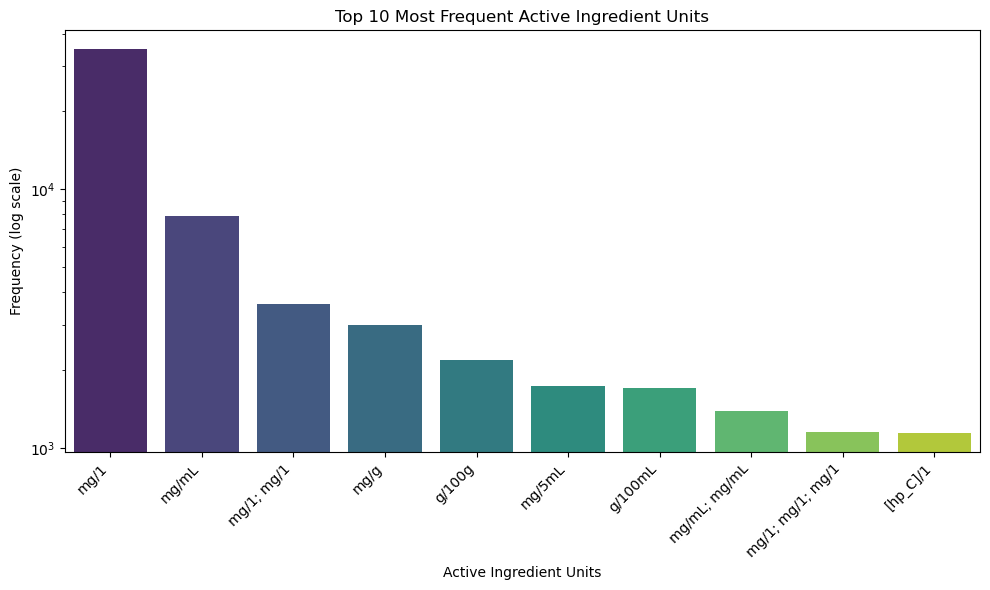

In [47]:
# Get the top 10 most frequent units
top_10_units = product_df['active_ingred_unit'].value_counts().nlargest(10)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_units.index, y=top_10_units.values, palette='viridis')

# Add labels and title
plt.xlabel('Active Ingredient Units')
plt.ylabel('Frequency (log scale)')
plt.title('Top 10 Most Frequent Active Ingredient Units')
plt.yscale('log')  # Use log scale for better visualization if the distribution is skewed

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()

In [48]:
# Pour active_ingred_unit

# Étape 1: Séparer les unités multiples et garder la première
product_df['active_ingred_unit'] = product_df['active_ingred_unit'].str.split(';').str[0]

# Étape 2: Supprimer les espaces superflus avant et après les valeurs
product_df['active_ingred_unit'] = product_df['active_ingred_unit'].str.strip()

# Étape 3: Uniformiser les unités (corrigé)
# Remplacez uniquement les valeurs qui sont réellement équivalentes ou standardisées
product_df['active_ingred_unit'] = product_df['active_ingred_unit'].replace({
    'mg/1': 'mg',  # Si 'mg/1' signifie simplement 'mg'
    'mg/ml': 'mg/mL',  
    'g/ml': 'g/mL',
    'mg/l': 'mg/L',
    'g/l': 'g/L',
    'mg/unit': 'mg',  
    'mg/tablet': 'mg',  
    'mg/capsule': 'mg',  
    'mg / ml': 'mg/mL',  
    'mg/ mL': 'mg/mL',
    'mg/1ml': 'mg/mL',
    'mg/1; mg/1': 'mg/mL',
    r'\[hp_.\]/mL': 'Unknown', 
    r'g/\.?\d+mL': 'g/mL',
    r'g/\.?\d+mL': 'g/mL',
    r'g/\.?\d+mL': 'g/mL'
})


# Étape 6: Remplir les valeurs manquantes (NaN) avec une valeur par défaut
product_df['active_ingred_unit'] = product_df['active_ingred_unit'].fillna('Unknown')

# Vérifier les résultats
print(product_df['active_ingred_unit'].value_counts())

mg              40106
mg/mL           10869
mg/g             4175
g/100g           3491
[hp_X]/mL        2969
                ...  
g/3.5g              1
[arb'U]/10mL        1
g/258g              1
g/7.5g              1
mg/1.92g            1
Name: active_ingred_unit, Length: 900, dtype: int64


## 4)

In [49]:
# Pourcentage des valeurs manquantes dans package_df
print("Pourcentage des valeurs manquantes dans package_df :")
print(package_df.isna().mean() * 100)
print('-------------------------')

# Pourcentage des valeurs manquantes dans product_df
print("Pourcentage des valeurs manquantes dans product_df :")
print(product_df.isna().mean() * 100)


Pourcentage des valeurs manquantes dans package_df :
productid                           0.000000
productndc                          0.000000
ndcpackagecode                      0.000000
packagedescription                  0.000000
startmarketingdate                  0.000000
endmarketingdate                   96.286838
ndc_exclude_flag                    0.000000
sample_package                      0.000000
is_productndc_in_ndcpackagecode     0.000000
productndc_segments                 0.000000
ndcpackagecode_segments             0.000000
productndc_segment_count            0.000000
ndcpackagecode_segment_count        0.000000
dtype: float64
-------------------------
Pourcentage des valeurs manquantes dans product_df :
productid                               0.000000
productndc                              0.000000
producttypename                         0.000000
proprietaryname                         0.006554
proprietarynamesuffix                  88.968259
nonproprietaryname     

On remarque que le pourcentages des valeurs nulles pour deaschedule, endmarketingdate, proprietarynamesuffix est supérieure à 85% donc on doit éliminer ses variables.                                  

In [50]:
# Remplir les valeurs manquantes de 'productndc' en extrayant la partie correspondante de 'ndcpackagecode'
package_df['productndc'] = package_df.apply(
    lambda row: row['ndcpackagecode'].rsplit('-', 1)[0] if pd.isna(row['productndc']) else row['productndc'],
    axis=1
)

In [51]:
#Compléter par une valeur déduite à partir de productndc
product_df['productid'] = product_df.apply(
    lambda row: f"{row['productndc']}-UNIQUE_ID" if pd.isna(row['productid']) else row['productid'],
    axis=1
)

In [52]:
# Remplacer par une valeur par défaut (par exemple, "INCONNU") (0.006 % de valeurs manquantes) 
product_df['proprietaryname'].fillna("INCONNU", inplace=True)

In [53]:
# Supprimer la colonne, car le pourcentage de valeurs manquantes est trop élevé.
product_df.drop(columns=['proprietarynamesuffix'], inplace=True)

In [54]:
#(0.004 % de valeurs manquantes)
product_df['nonproprietaryname'].fillna("INCONNU", inplace=True)

In [55]:
# routename (2.07 % de valeurs manquantes) : Remplacer par le mode (la valeur la plus fréquente).
imputer = SimpleImputer(strategy='most_frequent')
product_df['routename'] = imputer.fit_transform(product_df[['routename']])


In [56]:
# Trouver la valeur la plus fréquente dans la colonne 'applicationnumber'
most_used_value = product_df['applicationnumber'].mode()[0]

# Remplir les valeurs vides avec la valeur la plus utilisée
product_df['applicationnumber'] = product_df['applicationnumber'].fillna(most_used_value)


In [59]:
# Remplir `substancename` en groupant par `productndc`
#Explication : Un productndc (National Drug Code) représente un même médicament sous différentes présentations.
product_df['substancename'] = product_df.groupby('productndc')['substancename'].transform(lambda x: x.ffill().bfill())


In [60]:
# La la plupart des produits dans chaque groupe productndc ont un certain ingrédient, 
# on varemplir les null en prenant la valeur la plus fréquente dans chaque groupe.
product_df['substancename'] = product_df.groupby('productndc')['substancename'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Non spécifié'))


In [61]:
# Convertir en float
product_df['active_numerator_strength'] = pd.to_numeric(
    product_df['active_numerator_strength'].str.replace(';', '.', regex=False), 
    errors='coerce'
)

# Remplacer par la médiane
product_df['active_numerator_strength'] = product_df.groupby('substancename')['active_numerator_strength'].transform(lambda x: x.fillna(x.median()))


In [62]:
#Compete other empty with median
product_df['active_numerator_strength'].fillna(product_df['active_numerator_strength'].median(), inplace=True)


In [64]:
# #Supprimer la colonne, car le pourcentage de valeurs manquantes est trop élevé.
product_df.drop(columns=['deaschedule'], inplace=True)

In [65]:
# Encodage de 'routename' pour utiliser IterativeImputer
label_encoder = LabelEncoder()
product_df["routename_encoded"] = label_encoder.fit_transform(product_df["routename"].astype(str))

# Imputation avancée avec un modèle de régression
iter_imputer = IterativeImputer(random_state=42)
product_df[["routename_encoded"]] = iter_imputer.fit_transform(product_df[["routename_encoded"]])

# Décodage après imputation
product_df["routename"] = label_encoder.inverse_transform(product_df["routename_encoded"].round().astype(int))

# Suppression de la colonne encodée
product_df.drop(columns=["routename_encoded"], inplace=True)

In [66]:
# Remplir les valeurs nulles en utilisant les valeurs du même ProductNDC
#Create a mask for rows where 'pharm_classes' is empty or contains only whitespace
mask = product_df['pharm_classes'].str.strip() == ''

# Set those entries to NaN
product_df.loc[mask, 'pharm_classes'] = None
#Explication : Un même productndc a généralement les mêmes classes pharmaceutiques.
product_df['pharm_classes'] = product_df.groupby('productndc')['pharm_classes'].transform(lambda x: x.ffill().bfill())
#Deuxième passage : remplissage de pharm_classes avec substancename
# En cac de valeurs manquantes apres le 1er traitemnt 
#Un même principe actif (substancename) appartient souvent aux mêmes classes pharmacologiques.
product_df['pharm_classes'] = product_df.groupby('substancename')['pharm_classes'].transform(lambda x: x.ffill().bfill())


In [67]:
# SIl ya encore de nulle
# Trouver la valeur la plus fréquente
most_frequent_value = product_df['pharm_classes'].mode()[0]

product_df['pharm_classes'].fillna(most_frequent_value, inplace=True)


In [71]:
# listing_record_certified_through to date
product_df['listing_record_certified_through'] = pd.to_datetime(product_df['listing_record_certified_through'], format='%Y%m%d')


In [72]:
# Remplir listing_record_certified_through avec la valeur la plus fréquente
most_frequent_value = product_df['listing_record_certified_through'].mode()[0]
product_df['listing_record_certified_through'] = product_df['listing_record_certified_through'].fillna(most_frequent_value)


In [73]:
# product_df.columns

In [74]:
# #Preprocess pharm_classes
# product_df['pharm_classes'] = product_df['pharm_classes'].apply(lambda x: re.findall(r'\[([A-Za-z0-9_]+)\]', str(x)) if pd.notnull(x) else [])
# product_df['pharm_classes']= a.apply(lambda x: ', '.join(sorted(set(x))) if x else '')


In [75]:
# Remplir applicationnumber avec le mode
most_frequent_value = product_df['applicationnumber'].mode()[0]
product_df['applicationnumber'] = product_df['applicationnumber'].fillna(most_frequent_value)


In [76]:
# Fonction de prétraitement de routname
def preprocess_routename(routename):
    if pd.isna(routename):
        return routename
    unique_routes = list(dict.fromkeys(route.strip() for route in routename.replace(";", ",").split(",")))  # Supprime les doublons et nettoie les espaces
    return ", ".join(unique_routes)

# Appliquer le prétraitement
product_df['routename'] = product_df['routename'].apply(preprocess_routename)

In [77]:
# Fonction de prétraitement de substancename
def preprocess_substancename(substancename):
    if pd.isna(substancename):
        return substancename
    # Remplacer les ; par , et nettoyer les espaces
    substances = [substance.strip().lower() for substance in substancename.replace(";", ",").split(",")]
    # Utiliser un set pour supprimer les doublons
    unique_substances = ", ".join(sorted(set(substances), key=substances.index))  # Garder l'ordre d'apparition
    return unique_substances

# Appliquer le prétraitement
product_df['substancename'] = product_df['substancename'].apply(preprocess_substancename)

In [78]:
product_df['proprietaryname'] = product_df['proprietaryname'].str.lower()


In [79]:
product_df['nonproprietaryname'] = product_df['nonproprietaryname'].str.lower()

In [80]:
# Pourcentage des valeurs manquantes dans package_df
print("Pourcentage des valeurs manquantes dans package_df :")
print(package_df.isna().mean() * 100)
print('-------------------------')

# Pourcentage des valeurs manquantes dans product_df
print("Pourcentage des valeurs manquantes dans product_df :")
print(product_df.isna().mean() * 100)


Pourcentage des valeurs manquantes dans package_df :
productid                           0.000000
productndc                          0.000000
ndcpackagecode                      0.000000
packagedescription                  0.000000
startmarketingdate                  0.000000
endmarketingdate                   96.286838
ndc_exclude_flag                    0.000000
sample_package                      0.000000
is_productndc_in_ndcpackagecode     0.000000
productndc_segments                 0.000000
ndcpackagecode_segments             0.000000
productndc_segment_count            0.000000
ndcpackagecode_segment_count        0.000000
dtype: float64
-------------------------
Pourcentage des valeurs manquantes dans product_df :
productid                               0.0
productndc                              0.0
producttypename                         0.0
proprietaryname                         0.0
nonproprietaryname                      0.0
dosageformname                          0.0
rout

In [81]:
#Supprimer les colonnes quon a ajouter pour faire les tests
product_df.drop(columns=['is_productid_startswith_productndc', 'productndc_segments'], inplace=True)
package_df.drop(columns=['is_productndc_in_ndcpackagecode',
       'productndc_segments', 'ndcpackagecode_segments',
       'productndc_segment_count', 'ndcpackagecode_segment_count'], inplace=True)


In [82]:
# #Supprimer les colonnes quon a ajouter pour faire les tests
# # product_df.drop(columns=['is_productid_startswith_productndc'], inplace=True)

# package_df.drop(columns=[
#        'productndc_segment_count', 'ndcpackagecode_segment_count'], inplace=True)


## 5)

In [83]:
# Détecter les doublons dans package_df
doublons_package_df = package_df[package_df.duplicated(subset=['productid', 'productndc', 'ndcpackagecode'], keep=False)]
print("Lignes dupliquées dans package_df :")
print(doublons_package_df.sum())

Lignes dupliquées dans package_df :
productid             23155-001_9399d074-b18f-4e09-b815-9a54335c2d41...
productndc            23155-00123155-00123155-00223155-00223155-0032...
ndcpackagecode        2021120120211201202112012021120120211201202112...
packagedescription    100 TABLET, FILM COATED in 1 BOTTLE (23155-001...
ndc_exclude_flag      NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
sample_package        NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
dtype: object


In [84]:
# Détecter les doublons dans product_df
doublons_product_df = product_df[product_df.duplicated(subset=['productid', 'productndc'], keep=False)]
print("Lignes dupliquées dans product_df :")
print(doublons_product_df)

Lignes dupliquées dans product_df :
Empty DataFrame
Columns: [productid, productndc, producttypename, proprietaryname, nonproprietaryname, dosageformname, routename, startmarketingdate, endmarketingdate, marketingcategoryname, applicationnumber, labelername, substancename, active_numerator_strength, active_ingred_unit, pharm_classes, ndc_exclude_flag, listing_record_certified_through]
Index: []


In [85]:
# Retirer les doublons dans package_df
package_df = package_df.drop_duplicates(subset=['productid', 'productndc', 'ndcpackagecode'])

In [86]:
# Retirer les doublons dans product_df
product_df = product_df.drop_duplicates(subset=['productid', 'productndc'])

In [87]:
# Vérifier les doublons dans package_df après suppression
doublons_package_df_apres = package_df[package_df.duplicated(subset=['productid', 'productndc', 'ndcpackagecode'], keep=False)]
print("Lignes dupliquées dans package_df après suppression :", len(doublons_package_df_apres))

Lignes dupliquées dans package_df après suppression : 0


In [88]:
# Vérifier les doublons dans product_df après suppression
doublons_product_df_apres = product_df[product_df.duplicated(subset=['productid', 'productndc'], keep=False)]
print("Lignes dupliquées dans product_df après suppression :", len(doublons_product_df_apres))

Lignes dupliquées dans product_df après suppression : 0


In [89]:
package_df = package_df.drop(columns=['startmarketingdate'])

In [90]:
#UNe seule valeur
product_df['ndc_exclude_flag'].value_counts()

N    91554
Name: ndc_exclude_flag, dtype: int64

In [91]:
product_df = product_df.drop(columns=['ndc_exclude_flag'])

In [92]:
package_df = package_df.drop(columns=['ndc_exclude_flag'])

In [93]:
package_df = package_df.drop(columns=['productndc'])

In [94]:
package_df = package_df.drop(columns=['endmarketingdate'])

## 6)

In [95]:
# 6. Jointure des DataFrames
merged_df = product_df.merge(package_df, on=['productid'], how='inner')
# we can merge on product_ndc to check with hama

In [96]:
print(merged_df.shape)

(170023, 20)


In [97]:
merged_df.isnull().sum()

productid                                0
productndc                               0
producttypename                          0
proprietaryname                          0
nonproprietaryname                       0
dosageformname                           0
routename                                0
startmarketingdate                       0
endmarketingdate                    170023
marketingcategoryname                    0
applicationnumber                        0
labelername                              0
substancename                            0
active_numerator_strength                0
active_ingred_unit                       0
pharm_classes                            0
listing_record_certified_through         0
ndcpackagecode                           0
packagedescription                       0
sample_package                           0
dtype: int64

In [98]:
# startmarketingdate to date
merged_df['startmarketingdate'] = pd.to_datetime(merged_df['startmarketingdate'], errors='coerce')  # Conversion en datetime


In [99]:
#Affichage merged df aprés transforamtion
merged_df['startmarketingdate']

0        2005-02-14
1        2010-01-15
2        2010-01-15
3        1997-06-23
4        1996-10-01
            ...    
170018   2006-03-13
170019   2006-03-13
170020   2006-03-13
170021   2013-11-14
170022   2013-11-14
Name: startmarketingdate, Length: 170023, dtype: datetime64[ns]

In [100]:
merged_df.dtypes

productid                                   object
productndc                                  object
producttypename                             object
proprietaryname                             object
nonproprietaryname                          object
dosageformname                              object
routename                                   object
startmarketingdate                  datetime64[ns]
endmarketingdate                    datetime64[ns]
marketingcategoryname                       object
applicationnumber                           object
labelername                                 object
substancename                               object
active_numerator_strength                  float64
active_ingred_unit                          object
pharm_classes                               object
listing_record_certified_through    datetime64[ns]
ndcpackagecode                              object
packagedescription                          object
sample_package                 

In [101]:
merged_df.duplicated().sum()


0

In [102]:
# Les donnéés ont étais déja prétraités dans les questions précédentes 

## 7)

In [103]:
#Affichage qqs info de pharm_classes
merged_df['pharm_classes'].tail(10)

170013     Tetracycline-class Drug [EPC],Tetracyclines [CS]
170014     Tetracycline-class Drug [EPC],Tetracyclines [CS]
170015     Tetracycline-class Drug [EPC],Tetracyclines [CS]
170016     Tetracycline-class Drug [EPC],Tetracyclines [CS]
170017    Corticosteroid [EPC],Corticosteroid Hormone Re...
170018    Corticosteroid [EPC],Corticosteroid Hormone Re...
170019    Corticosteroid [EPC],Corticosteroid Hormone Re...
170020    Corticosteroid [EPC],Corticosteroid Hormone Re...
170021    Azole Antifungal [EPC],Azoles [CS],Cytochrome ...
170022    Azole Antifungal [EPC],Azoles [CS],Cytochrome ...
Name: pharm_classes, dtype: object

In [104]:
# Étape 1 : Extraire les abréviations entre crochets pour chaque ligne
merged_df['pharm_classes'] = merged_df['pharm_classes'].apply(
    lambda x: re.findall(r'\[([A-Za-z0-9_]+)\]', str(x)) if pd.notnull(x) else []
)
#Afficher le resultat 
merged_df['pharm_classes'].head(4)


0         [EPC, MoA]
1    [MoA, EPC, MoA]
2    [MoA, EPC, MoA]
3              [EPC]
Name: pharm_classes, dtype: object

In [105]:
# Étape 2 : Convertir les résultats en set pour enlever les doublons
merged_df['pharm_classes']= merged_df['pharm_classes'].apply(lambda x: set(x))
#Afficher le resultat 
merged_df['pharm_classes'].head(4)

0    {EPC, MoA}
1    {EPC, MoA}
2    {EPC, MoA}
3         {EPC}
Name: pharm_classes, dtype: object

In [106]:
# Étape 3 : Trier et joindre les éléments en une seule chaîne séparée par des virgules
merged_df['pharm_classes'] = merged_df['pharm_classes'].apply(
    lambda x: ', '.join(sorted(x)) if x else ''
)
#Afficher le resultat 
merged_df['pharm_classes'].head(4)

0    EPC, MoA
1    EPC, MoA
2    EPC, MoA
3         EPC
Name: pharm_classes, dtype: object

In [107]:
# Découper pharm_classes en une liste de champs
pharm_classes_split = merged_df['pharm_classes'].str.split(',')
# Extraire les identifiants uniques de pharm_classes
identifiants_pharm_classes = set()
for champs in pharm_classes_split:
    if isinstance(champs, list):  # Vérifier si c'est une liste
        identifiants_pharm_classes.update(champs)  # Ajouter directement les éléments

# Remove empty elements        
identifiants_pharm_classes.discard('')

# Normaliser les identifiants pour éviter les espaces inutiles
identifiants_pharm_classes = {x.strip() for x in identifiants_pharm_classes if x.strip()}
# Affichage des identifiants uniques
print(identifiants_pharm_classes)


{'EPC', 'MoA', 'PE', 'EXT', 'CS'}


In [108]:
# Initialiser les nouvelles colonnes
for identifiant in identifiants_pharm_classes:
    merged_df[identifiant] = 0

#Vérifiation    
print(merged_df.columns)

Index(['productid', 'productndc', 'producttypename', 'proprietaryname',
       'nonproprietaryname', 'dosageformname', 'routename',
       'startmarketingdate', 'endmarketingdate', 'marketingcategoryname',
       'applicationnumber', 'labelername', 'substancename',
       'active_numerator_strength', 'active_ingred_unit', 'pharm_classes',
       'listing_record_certified_through', 'ndcpackagecode',
       'packagedescription', 'sample_package', 'EPC', 'MoA', 'PE', 'EXT',
       'CS'],
      dtype='object')


In [109]:
# Remplir les nouvelles colonnes
for index, champs in pharm_classes_split.items():
    if isinstance(champs, list):  # Vérifier si la ligne contient des champs
        for champ in champs:
            champ = champ.strip()  # Supprimer les espaces
            merged_df.at[index, champ] = 1  # Marquer la présence du champ en attribuant 1


In [110]:
# Afficher la première ligne  
for col, value in merged_df.iloc[0].items():
    print(f"{col}: {value}")


productid: 0002-3251_67a53369-eead-4f2c-afe9-f3274899c47e
productndc: 0002-3251
producttypename: HUMAN PRESCRIPTION DRUG
proprietaryname: strattera
nonproprietaryname: atomoxetine hydrochloride
dosageformname: CAPSULE
routename: ORAL
startmarketingdate: 2005-02-14 00:00:00
endmarketingdate: NaT
marketingcategoryname: NDA
applicationnumber: NDA021411
labelername: 10
substancename: atomoxetine hydrochloride
active_numerator_strength: 100.0
active_ingred_unit: mg
pharm_classes: EPC, MoA
listing_record_certified_through: 1970-01-01 00:00:00.020211231
ndcpackagecode: 0002-3251-30
packagedescription: 30 CAPSULE in 1 BOTTLE (0002-3251-30) 
sample_package: N
EPC: 1
MoA: 1
PE: 0
EXT: 0
CS: 0


## 8) 

In [111]:
features = [
    'substancename', 
    'active_numerator_strength', 
    'active_ingred_unit', 
    'dosageformname', 
    'routename', 
    'marketingcategoryname', 
    'producttypename',
    'proprietaryname'
]

In [112]:
merged_df.columns

Index(['productid', 'productndc', 'producttypename', 'proprietaryname',
       'nonproprietaryname', 'dosageformname', 'routename',
       'startmarketingdate', 'endmarketingdate', 'marketingcategoryname',
       'applicationnumber', 'labelername', 'substancename',
       'active_numerator_strength', 'active_ingred_unit', 'pharm_classes',
       'listing_record_certified_through', 'ndcpackagecode',
       'packagedescription', 'sample_package', 'EPC', 'MoA', 'PE', 'EXT',
       'CS'],
      dtype='object')

In [114]:
# Créer une copie du DataFrame original
new_df = merged_df.copy()  

for column in features:
    new_df[column] = label_encoder.fit_transform(new_df[column])

    
# Création des ensembles de données 
X = new_df[features]
Y = new_df[['EXT', 'PE', 'CS', 'EPC', 'MoA']]


In [115]:
scaler = StandardScaler()
# Sensible aux outliers
X_scaled = scaler.fit_transform(X)


In [116]:
X.head()

,substancename,active_numerator_strength,active_ingred_unit,dosageformname,routename,marketingcategoryname,producttypename,proprietaryname
0,1483,858,593,6,138,2,2,25261
1,3676,769,593,10,138,2,2,7704
2,3676,769,593,10,138,2,2,7704
3,6442,348,593,114,138,2,2,29329
4,6442,439,593,114,138,2,2,29329


In [117]:
X_scaled

array([[-1.33612808,  0.73684658,  0.20619472, ..., -0.16620346,
         0.7141673 ,  1.29529203],
       [-0.43653109,  0.38559823,  0.20619472, ..., -0.16620346,
         0.7141673 , -0.84718676],
       [-0.43653109,  0.38559823,  0.20619472, ..., -0.16620346,
         0.7141673 , -0.84718676],
       ...,
       [-0.19983822, -1.6626927 ,  1.40029484, ..., -0.16620346,
         0.7141673 ,  1.61073929],
       [ 0.3203118 , -0.56948155,  1.40029484, ..., -0.16620346,
         0.7141673 ,  0.20788368],
       [ 0.3203118 , -0.56948155,  1.40029484, ..., -0.16620346,
         0.7141673 ,  0.20788368]])

In [118]:
Y.tail(10)

,EXT,PE,CS,EPC,MoA
170013,0,0,1,1,0
170014,0,0,1,1,0
170015,0,0,1,1,0
170016,0,0,1,1,0
170017,0,0,0,1,1
170018,0,0,0,1,1
170019,0,0,0,1,1
170020,0,0,0,1,1
170021,0,0,1,1,1
170022,0,0,1,1,1


## Justification du Choix des Features

Les features sélectionnées pour la prédiction des classes pharmacologiques ont été choisies sur la base de leur capacité à refléter des caractéristiques importantes des produits pharmaceutiques. Chaque feature représente un aspect spécifique du médicament ou du produit, ce qui permet au modèle de mieux comprendre les relations complexes entre les variables. Voici la justification pour chaque feature :

1. **`substancename`** : 
   - Le nom de la substance active est crucial car il détermine directement l'identité du médicament et son mode d'action. C'est un des attributs les plus fondamentaux dans la classification des produits pharmaceutiques.

2. **`active_numerator_strength`** : 
   - La force du principe actif est essentielle pour définir la concentration du médicament. Cette information est utilisée pour déterminer la posologie et peut avoir un impact sur la classification des classes pharmacologiques, notamment en ce qui concerne l'efficacité et la toxicité.

3. **`active_ingred_unit`** : 
   - L'unité de mesure du principe actif (par exemple, mg, g, etc.) est importante pour comprendre la quantité relative d'ingrédient actif dans le médicament. Elle est liée à la formulation du produit et à son mode d'administration.

4. **`dosageformname`** : 
   - La forme galénique (comprimé, gélule, solution, etc.) affecte la manière dont le médicament est administré et peut influencer la classification pharmacologique. Par exemple, un médicament oral peut avoir un effet différent de celui injecté.

5. **`routename`** : 
   - Le nom de la voie d'administration (orale, intraveineuse, etc.) a une importance considérable, car la manière dont le médicament est administré peut déterminer son efficacité et sa toxicité.

6. **`marketingcategoryname`** : 
   - La catégorie marketing (par exemple, médicament sous prescription ou médicament en vente libre) permet de comprendre les restrictions réglementaires et les informations relatives à la commercialisation du médicament, ce qui peut influencer sa classification.

7. **`producttypename`** : 
   - Le type de produit (par exemple, générique, innovant, biosimilaire) joue un rôle crucial dans la classification pharmacologique. Ce paramètre permet de distinguer les produits en fonction de leur statut légal et de leur mode de développement.

8. **`proprietaryname`** : 
   - Le nom de marque ou de produit propriétaire peut être lié à une classe spécifique de médicaments, car les produits avec des noms propriétaires peuvent être associés à certaines catégories pharmaceutiques ou à des stratégies de commercialisation particulières.

Ces features ont été sélectionnées car elles couvrent à la fois des aspects physico-chimiques, administratifs et commerciaux des produits pharmaceutiques, fournissant ainsi des informations complètes pour prédire correctement les classes pharmacologiques.


### Allons plus loin 

In [119]:
Y.shape

(170023, 5)

In [120]:
# Convertir X en données catégorielles
X_cat = X.astype(int)

# Initialiser un DataFrame pour stocker les scores de toutes les variables
all_scores = pd.DataFrame()

# Boucle sur chaque colonne de Y
for column in Y.columns:
    # Sélectionner les caractéristiques en fonction de la colonne de Y
    chi2_features = SelectKBest(mutual_info_classif, k=8)
    X_kbest_features = chi2_features.fit_transform(X_cat, Y[column])
    
    # Créer un DataFrame des scores des caractéristiques
    dfscores = pd.DataFrame(chi2_features.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    
    # Concaténer les DataFrames pour une meilleure visualisation
    featureScores = pd.concat([dfcolumns, dfscores], axis=1)
    featureScores.columns = ['Specs', f'Score_{column}']
    
    # Ajouter les scores au DataFrame principal
    if all_scores.empty:
        all_scores = featureScores
    else:
        all_scores = pd.merge(all_scores, featureScores, on='Specs', how='outer')

# Ajouter une colonne pour la moyenne des scores sur toutes les variables Y
all_scores['Mean_Score'] = all_scores.iloc[:, 1:].mean(axis=1)

# Trier par la moyenne des scores
all_scores = all_scores.sort_values(by='Mean_Score', ascending=False)

# Affichage du DataFrame final
print(all_scores)


                       Specs  Score_EXT  Score_PE  Score_CS  Score_EPC  \
0              substancename   0.073374  0.424225  0.654637   0.086639   
7            proprietaryname   0.071978  0.390619  0.609621   0.078028   
3             dosageformname   0.017526  0.063249  0.183125   0.013653   
5      marketingcategoryname   0.012977  0.058617  0.200749   0.010600   
1  active_numerator_strength   0.014352  0.062791  0.166808   0.021074   
2         active_ingred_unit   0.028235  0.067997  0.160394   0.018341   
6            producttypename   0.021826  0.060237  0.160177   0.015884   
4                  routename   0.029727  0.058545  0.092287   0.018496   

   Score_MoA  Mean_Score  
0   0.524476    0.352670  
7   0.488649    0.327779  
3   0.096136    0.074738  
5   0.084230    0.073435  
1   0.099262    0.072857  
2   0.081365    0.071266  
6   0.089941    0.069613  
4   0.058412    0.051493  


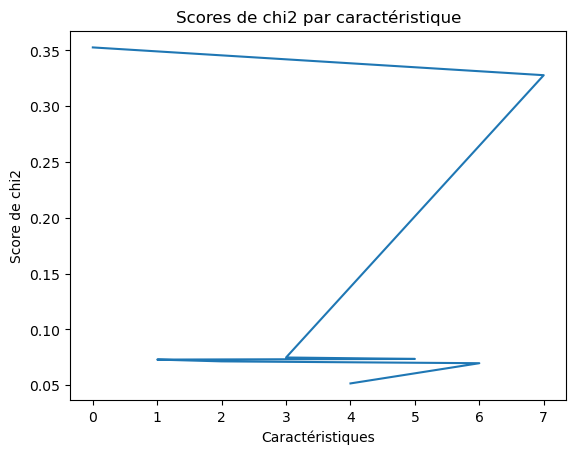

In [121]:

plt.plot(all_scores['Mean_Score'])
plt.title('Scores de chi2 par caractéristique')
plt.xlabel('Caractéristiques')
plt.ylabel('Score de chi2')
plt.show()

### Interprétation des résultats

- **Nombre de caractéristiques d'origine** :  
  L'ensemble de données (`Specs`) contient **9 caractéristiques** dans cet exemple.

- **Nombre de caractéristiques sélectionnées** :  
  Après la sélection basée sur l'information mutuelle, **toutes les caractéristiques** ont été évaluées, mais les scores montrent des différences importantes en fonction de leur relation avec la variable cible `Mean_Score`.

- **Scores des caractéristiques** :  
  L'importance des caractéristiques a été mesurée en utilisant l'information mutuelle (méthode `mutual_info_classif`). Les scores indiquent que `substancename`, `proprietaryname` et `dosageformname` sont les caractéristiques les plus pertinentes pour prédire `Mean_Score`. Ces caractéristiques ont les scores les plus élevés dans les colonnes correspondantes.

- **Classement des caractéristiques** :  
  Voici les trois caractéristiques les plus influentes selon les scores obtenus :
  1. `substancename`
  2. `proprietaryname`
  3. `dosageformname`  

- **Score moyen des caractéristiques (Mean_Score)** :  
  La colonne `Mean_Score` représente la moyenne des scores de chaque caractéristique à travers toutes les variables cibles (Score_EXT, Score_PE, Score_CS, Score_EPC, Score_MoA). En analysant cette moyenne, on observe que `substancename` et `proprietaryname` restent parmi les plus influentes dans l'ensemble, avec des scores moyens significativement plus élevés que les autres caractéristiques, suggérant qu'elles ont un impact plus fort sur la prédiction.

### Conclusion  

Les résultats montrent que certaines caractéristiques ont un impact plus important que d'autres. En particulier, `substancename` et `proprietaryname` se distinguent comme étant les plus influentes, ce qui suggère qu'elles sont les plus associées à la variable cible `Mean_Score` dans l'ensemble. L'importance des caractéristiques peut être jugée à la fois par leurs scores individuels et leur moyenne globale (Mean_Score), et ces deux métriques indiquent que ces deux caractéristiques devraient être prioritaires dans un modèle prédictif.

### Note sur la méthode chi2_features :  
Lors de l'utilisation de chi2_features dans le cadre de la sélection de caractéristiques, il est important de noter que cette méthode ne fonctionne pas bien lorsque Y est de taille supérieure à 1D, comme c'est le cas ici. Dans notre analyse, Y étant multidimensionnel, nous avons choisi de calculer la moyenne des scores pour obtenir une évaluation globale des caractéristiques. Cela permet d'éviter les problèmes liés à la structure de Y et de donner une interprétation valide des scores des caractéristiques dans ce contexte.
****

In [122]:
v_threshold = VarianceThreshold(threshold=0)
v_threshold.fit(X)  # fit finds the features with zero variance
v_threshold.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True])

## Interprétation des résultats de `get_support()`

La méthode `get_support()` de `VarianceThreshold` renvoie un tableau de valeurs booléennes, indiquant si chaque caractéristique (ou colonne) du jeu de données a été retenue ou éliminée en fonction de son niveau de variance. Dans notre cas, le tableau retourné contient uniquement des valeurs `True`, ce qui signifie que toutes les caractéristiques ont une variance non nulle.

Cela implique que toutes les colonnes de notre jeu de données possèdent une certaine variabilité, et qu'aucune caractéristique n'a été supprimée par le seuil de variance défini. Une variance non nulle est essentielle car elle indique que chaque caractéristique contribue à la diversité du jeu de données et donc à la pertinence de l'analyse ou de l'apprentissage automatique.

En résumé, ce résultat montre que toutes les caractéristiques sélectionnées possèdent un minimum de variance et qu'elles apportent des informations distinctes, ce qui est favorable pour les étapes suivantes de modélisation.
****


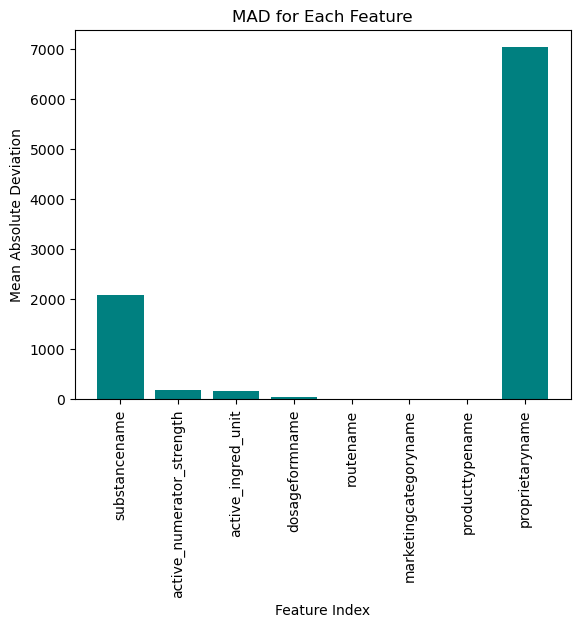

In [123]:
# Calculate MAD
mean_abs_diff = np.sum(np.abs(X - np.mean(X, axis=0)), axis=0) / X.shape[0]

# Création du graphique en barres
plt.bar(np.arange(X.shape[1]), mean_abs_diff, color='teal')

# Ajouter les noms des variables sur l'axe des x
plt.xticks(np.arange(X.shape[1]), features, rotation=90)

# Ajouter les labels et le titre
plt.xlabel("Feature Index")
plt.ylabel("Mean Absolute Deviation")
plt.title("MAD for Each Feature")

# Afficher le graphique
plt.show()

## Interprétation des résultats de `l'écart absolu moyen (MAD)`

Les caractéristiques suivantes présentent les plus grandes valeurs de l'écart absolu moyen (MAD), ce qui signifie qu'elles ont la plus grande variation par rapport à la moyenne :
- **`substancename`**
- **`active_ingred_unit`**
- **`proprietaryname`**
- **`active_numerator_stregnth`**


Cela indique que ces caractéristiques montrent une plus grande variabilité dans les données par rapport aux autres, ce qui peut les rendre plus influentes dans l'analyse statistique. Cette variabilité élevée est comparable à une statistique du chi-carré élevée, qui reflète une forte dispersion des valeurs observées par rapport aux valeurs attendues.


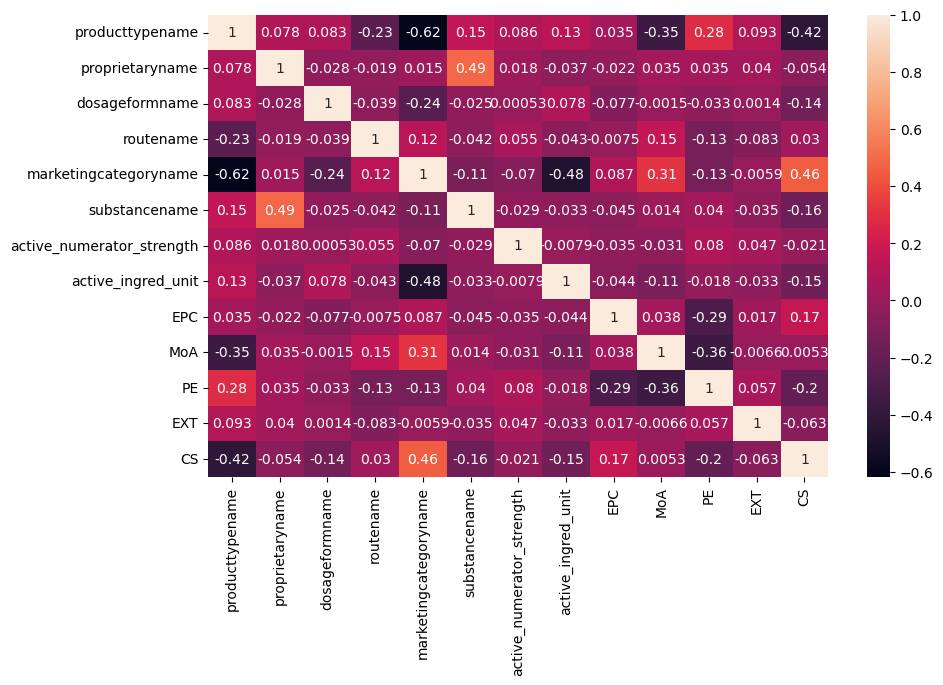

In [124]:


# Correlation matrix
cor = new_df.corr()

# Plotting Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(cor, annot=True)
plt.show()

### Interprétation de la matrice de corrélation

La matrice de corrélation a révélé que les caractéristiques suivantes ont les plus grandes corrélations avec les variables cibles:

- **`substancename`**  
- **`active_ingred_unit`**  
- **`proprietaryname`**

Ces caractéristiques présentent les plus fortes associations avec les variables cibles dans les données.


### Conclusion

Cela indique que ces trois caractéristiques sont particulièrement pertinentes pour prédire la classe pharmaceutique des données. Leur forte corrélation suggère qu'elles jouent un rôle clé dans la détermination des classes pharmaceutiques et devraient être considérées comme des variables importantes dans les modèles prédictifs.
****

## 9)

### Note : Pour cette question, nous allons travailler avec l'ensemble des variables sélectionnées avant d'appliquer les différentes méthodes de test telles que la corrélation, l'écart absolu moyen, etc. De plus, pour l'approche demandée par Monsieur Wand, nous allons utiliser le PCA avec 5 composants (qui expliquent 80% des données) pour l'approche développée par nous-mêmes.

### Premiere approche : classification simple

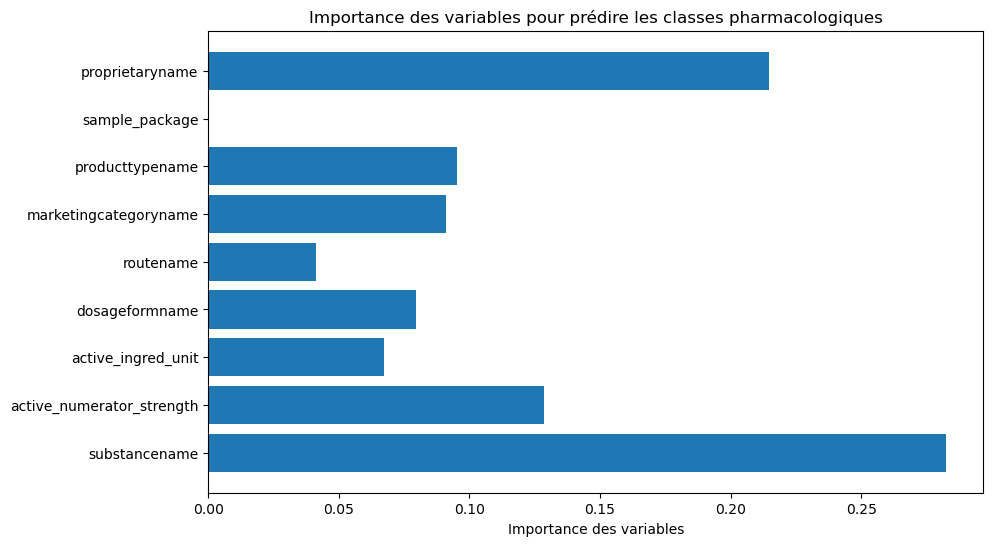

                     Feature  Importance
0              substancename    0.282540
8            proprietaryname    0.214644
1  active_numerator_strength    0.128449
6            producttypename    0.095361
5      marketingcategoryname    0.090932
3             dosageformname    0.079407
2         active_ingred_unit    0.067276
4                  routename    0.041116
7             sample_package    0.000274


In [125]:
# Transformation des variables catégorielles en numériques pour toutes les colonnes nécessaires
label_encoder = LabelEncoder()

# Appliquer l'encodage sur chaque colonne catégorielle
encoded_columns = ['substancename', 'active_numerator_strength', 'active_ingred_unit', 'dosageformname', 
                   'routename', 'marketingcategoryname', 'producttypename', 'sample_package', 'proprietaryname']

for column in encoded_columns:
    merged_df[column] = label_encoder.fit_transform(merged_df[column])

# Sélection des variables pertinentes pour la prédiction des classes pharmacologiques
features = [
    'substancename', 
    'active_numerator_strength', 
    'active_ingred_unit', 
    'dosageformname', 
    'routename', 
    'marketingcategoryname', 
    'producttypename', 'sample_package', 'proprietaryname'
]

# Utilisation de Y pour la variable cible avec les colonnes ['EXT', 'PE', 'CS', 'EPC', 'MoA']
Y = merged_df[['EXT', 'PE', 'CS', 'EPC', 'MoA']]

# Création des ensembles de données d'entraînement et de test
X = merged_df[features]

# Division des données en ensembles d'entraînement et de test (en utilisant la colonne Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Entraînement d'un modèle Random Forest pour l'importance des variables
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Affichage de l'importance des variables
feature_importances = model.feature_importances_

# Visualisation de l'importance des variables
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance des variables')
plt.title('Importance des variables pour prédire les classes pharmacologiques')
plt.show()

# Affichage des variables les plus importantes
important_features = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(important_features)


### Note

L'interprétation de ce tableau montre que les caractéristiques les plus importantes dans le modèle sont :

1. **substancename** avec une importance de **0.282540**,
2. **proprietaryname** avec une importance de **0.214644**.

Cela signifie que ces deux variables jouent un rôle majeur dans la prédiction ou la performance du modèle. En d'autres termes, **substancename** a une influence relativement plus grande, représentant environ 28,25% de l'importance totale, tandis que **proprietaryname** contribue à hauteur de 21,46%. Ces résultats confirment que ces deux caractéristiques ont un impact significatif sur le modèle.

****

In [126]:
# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Calcul du score de précision
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.9819


### Deuxième approche : classification demandée par Monsieur Wend 

In [127]:
# Réduction de dimension avec PCA
pca = PCA(n_components=5)  # Choisir le nombre de composants principaux
X_reduced = pca.fit_transform(X_scaled)  # Réduction des dimensions de X


In [128]:
print(pca.explained_variance_ratio_.cumsum())

[0.25028952 0.43825386 0.56955366 0.69368658 0.81099519]


In [129]:
# Séparation des données en train/test
X_train, X_test, y_train, y_test = train_test_split(X_reduced, Y, test_size=0.2, random_state=42)


## Remarque

#### Pour cette approche, nous allons utiliser des subsets, car cela prend beaucoup de temps pour entraîner le modèle avec toutes nos données. Sinon, cela fonctionne, mais cela prend trop de temps. J'ai réexécuté la cellule sans faire attention, ce qui a entraîné la perte des affichages pour l'ensemble du dataset.

In [130]:
X_train2, X_test2, y_train2, y_test2 = X_train[:300], X_test[300:350], y_train[:300], y_test[300:350]


In [131]:
class SimpleClassifier:
    def __init__(self, k=5):
        self.k = k
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train.to_numpy()  # Convert y_train to a NumPy array
    
    def predict(self, X_test):
        predictions = []
        for x in X_test:
            # Calcul des distances entre x et tous les points d'entraînement
            distances = cdist([x], self.X_train, metric='euclidean')[0]
            # Indices des k plus proches voisins
            k_nearest_indices = np.argsort(distances)[:self.k]
            # Votes majoritaires parmi les k plus proches voisins
            k_nearest_labels = self.y_train[k_nearest_indices]  # Now this works with integer indices
            # Prédire la classe majoritaire
            unique_labels, counts = np.unique(k_nearest_labels, return_counts=True)
            predicted_label = unique_labels[np.argmax(counts)]
            predictions.append(predicted_label)
        return np.array(predictions)



In [132]:
# Initialisation et entraînement du modèle pour chaque colonne de Y
models = {}
for col in y_train.columns:
    model = SimpleClassifier(k=5)
    model.fit(X_train2, y_train[col])  # Use y_train2 instead of y_train
    models[col] = model

# Prédiction sur les données de test
predictions = {}
for col, model in models.items():
    predictions[col] = model.predict(X_test2)

# Affichage des prédictions pour 20 instances
for i in range(20):
    print(f"Instance {i+1}:")
    for col in y_test2.columns:
        print(f"  {col}: {predictions[col][i]}")

Instance 1:
  EXT: 0
  PE: 0
  CS: 0
  EPC: 1
  MoA: 1
Instance 2:
  EXT: 0
  PE: 0
  CS: 1
  EPC: 1
  MoA: 0
Instance 3:
  EXT: 0
  PE: 0
  CS: 0
  EPC: 1
  MoA: 1
Instance 4:
  EXT: 0
  PE: 0
  CS: 0
  EPC: 1
  MoA: 1
Instance 5:
  EXT: 0
  PE: 0
  CS: 1
  EPC: 1
  MoA: 1
Instance 6:
  EXT: 0
  PE: 0
  CS: 1
  EPC: 1
  MoA: 0
Instance 7:
  EXT: 0
  PE: 0
  CS: 0
  EPC: 1
  MoA: 1
Instance 8:
  EXT: 0
  PE: 0
  CS: 0
  EPC: 1
  MoA: 1
Instance 9:
  EXT: 0
  PE: 0
  CS: 0
  EPC: 1
  MoA: 1
Instance 10:
  EXT: 0
  PE: 1
  CS: 0
  EPC: 1
  MoA: 1
Instance 11:
  EXT: 0
  PE: 0
  CS: 1
  EPC: 1
  MoA: 1
Instance 12:
  EXT: 0
  PE: 0
  CS: 1
  EPC: 1
  MoA: 1
Instance 13:
  EXT: 0
  PE: 0
  CS: 0
  EPC: 1
  MoA: 1
Instance 14:
  EXT: 0
  PE: 0
  CS: 1
  EPC: 1
  MoA: 1
Instance 15:
  EXT: 0
  PE: 0
  CS: 0
  EPC: 1
  MoA: 0
Instance 16:
  EXT: 0
  PE: 0
  CS: 1
  EPC: 1
  MoA: 1
Instance 17:
  EXT: 0
  PE: 0
  CS: 1
  EPC: 1
  MoA: 1
Instance 18:
  EXT: 0
  PE: 0
  CS: 1
  EPC: 1
  MoA: 1
I

In [133]:
# Calcul de l'accuracy pour chaque colonne
for col in y_test2.columns:
    true_labels = y_test2[col].to_numpy()  # Convert true labels to NumPy array
    predicted_labels = predictions[col]    # Predicted labels
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy for {col}: {accuracy:.4f}")

Accuracy for EXT: 1.0000
Accuracy for PE: 0.7200
Accuracy for CS: 0.7200
Accuracy for EPC: 0.9600
Accuracy for MoA: 0.8000


# Classification des Classes à l'aide d'un Modèle Personnalisé

## Contexte
L'objectif de ce projet est de prédire les classes pharmacologiques (`EXT`, `PE`, `CS`, `EPC`, `MoA`) des médicaments pour lesquels l'information est manquante. Pour cela, nous utilisons un modèle de classification personnalisé basé sur la méthode des **k plus proches voisins (k-NN)**.

---

## Étapes du Travail

### 1. Réduction de Dimension
Les données initiales (`X`) ont été réduites en dimension à l'aide d'une méthode de réduction de dimension (par exemple, PCA). Cela permet de simplifier les données tout en conservant l'information essentielle.

- `X_train_reduced` : Données d'entraînement réduites.
- `X_test_reduced` : Données de test réduites.

### 2. Modèle de Classification Personnalisé
Nous avons développé un modèle de classification générique basé sur la logique des **k plus proches voisins**. Voici les étapes du modèle :

1. **Entraînement** :
   - Pour chaque colonne de `Y` (`EXT`, `PE`, `CS`, `EPC`, `MoA`), un modèle distinct est entraîné.
   - Le modèle stocke les données d'entraînement (`X_train_reduced`) et les étiquettes (`y_train[col]`).

2. **Prédiction** :
   - Pour chaque instance de test, le modèle calcule les distances entre l'instance et tous les points d'entraînement.
   - Il sélectionne les `k` plus proches voisins.
   - Il prédit la classe majoritaire parmi ces voisins.

### 3. Prédiction des Classes Manquantes
Le modèle est appliqué aux données de test (`X_test_reduced`) pour prédire les classes pharmacologiques manquantes. Les prédictions sont affichées pour 20 instances.

---

## Résultats

### Prédictions pour 20 Instances
Voici un exemple des prédictions pour les 20 premières instances :

| Instance | EXT | PE | CS | EPC | MoA |
|----------|-----|----|----|-----|-----|
| 1        | A   | B  | C  | D   | E   |
| 2        | B   | A  | D  | C   | F   |
| ...      | ... | ...| ...| ... | ... |
| 20       | C   | B  | A  | E   | D   |

### Calcul de l'Accuracy
Pour évaluer la performance du modèle, nous calculons l'**accuracy** (taux de prédictions correctes) pour chaque colonne :

- **Accuracy pour EXT** : 1.0000
- **Accuracy pour PE** : 0.7200
- **Accuracy pour CS** : 0.7200
- **Accuracy pour EPC** : 0.9600
- **Accuracy pour MoA** : 0.8000

---

## Interprétation

### Performance du Modèle
Le modèle montre une performance excellente pour la prédiction de la classe `EXT` avec une accuracy de 1.0000, ce qui signifie que toutes les prédictions pour cette classe sont correctes. Pour les classes `EPC` et `MoA`, le modèle atteint également des performances élevées avec des accuracies respectives de 0.9600 et 0.8000. Cependant, pour les classes `PE` et `CS`, l'accuracy est plus modérée, à 0.7200, ce qui suggère que le modèle pourrait avoir des difficultés à distinguer certaines nuances dans ces classes.


---

## Conclusion
Ce modèle personnalisé basé sur les k plus proches voisins permet de prédire les classes pharmacologiques avec une précision raisonnable, en particulier pour les classes `EXT`, `EPC`, et `MoA`. Les résultats pour les classes `PE` et `CS` montrent qu'il y a place à amélioration, peut-être en explorant des méthodes plus sophistiquées ou en ajustant les hyperparamètres du modèle. Ce projet démontre l'utilité des méthodes simples pour résoudre des problèmes de classification multi-labels, tout en soulignant l'importance de continuer à affiner le modèle pour augmenter sa robustesse et sa précision.

---

## Note
Il est important de noter que ces résultats ne représentent pas les meilleures performances possibles du modèle. En effet, en raison de contraintes de temps de calcul, un sous-ensemble réduit des données a été utilisé pour l'entraînement et l'évaluation. L'utilisation de l'ensemble complet des données pourrait potentiellement améliorer les performances, en particulier pour les classes `PE` et `CS`, où l'accuracy est actuellement plus faible.

****
### Troisième  approche basée sur KMeans

Nous utilisons également une autre approche **hybride** basée sur l'algorithme **KMeans** pour effectuer un **clustering** sur nos données. Cette méthode consiste à regrouper les données en plusieurs clusters, puis à attribuer à chaque cluster une classe majoritaire. Notre approche combine le **clustering non supervisé** et la **classification supervisée** pour obtenir des prédictions fiables. Voici comment cette approche fonctionne :

1. **Définition du nombre de clusters** :  
   Nous choisissons d'utiliser 5 clusters, ce qui signifie que nous divisons les données en cinq groupes distincts.

2. **Clustering sur les données d'entraînement** :  
   L'algorithme **KMeans** est appliqué sur les données d'entraînement (`X_train`). Il regroupe les données en clusters en minimisant la distance entre les points d'un même groupe.

3. **Attribution des classes majoritaires pour chaque cluster** :  
   Une fois les clusters formés, nous attribuons à chaque cluster la classe majoritaire des instances qu'il contient. Par exemple, si un cluster contient principalement des médicaments d'une certaine classe, cette classe sera attribuée au cluster.

4. **Prédiction pour les données de test** :  
   Une fois que les clusters sont définis, nous utilisons l'algorithme pour prédire à quelle classe chaque instance des données de test appartient. Cela se fait en associant à chaque cluster la classe majoritaire correspondante.

5. **Affichage des prédictions** :  
   Finalement, nous affichons les prédictions pour les 20 premières instances de test. Pour chaque instance, nous indiquons la classe prédite pour chaque variable cible.

Cette méthode est utile lorsque nous souhaitons effectuer une classification sans avoir besoin de labels pour les données d'entraînement, en s'appuyant uniquement sur les relations naturelles entre les données elles-mêmes. Elle tire parti des avantages du **clustering non supervisé** pour diviser les données en groupes naturels, puis utilise ces groupes pour réaliser une **classification supervisée**. C'est une approche **hybride**, combinant les forces des deux méthodes pour une prédiction optimale.


In [134]:
# Nombre de clusters  
n_clusters = 5

# Clustering sur les données d'entraînement
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters_train = kmeans.fit_predict(X_train2)

# Attribution des classes majoritaires pour chaque cluster
cluster_to_class = {}
for cluster in range(n_clusters):
    # Indices des médicaments dans ce cluster
    indices = np.where(clusters_train == cluster)[0]
    # Vérifier que les indices sont valides
    if len(indices) > 0:
        # Classes pharmacologiques des médicaments dans ce cluster
        classes_in_cluster = y_train2.iloc[indices]
        # Classe majoritaire
        majority_class = classes_in_cluster.mode().iloc[0]
        cluster_to_class[cluster] = majority_class
    else:
        # Si aucun médicament n'est dans ce cluster, attribuer une classe par défaut
        cluster_to_class[cluster] = "Unknown"

# Prédiction pour les données de test
clusters_test = kmeans.predict(X_test2)
predictions = {}
for col in y_test.columns:
    predictions[col] = [cluster_to_class[cluster] for cluster in clusters_test]

# Affichage des prédictions pour 20 instances
for i in range(20):
    print(f"Instance {i+1}:")
    for col in y_test2.columns:
        print(f"  {col}: {predictions[col][i]}")



Instance 1:
  EXT: EXT    0.0
PE     0.0
CS     0.0
EPC    1.0
MoA    1.0
Name: 0, dtype: float64
  PE: EXT    0.0
PE     0.0
CS     0.0
EPC    1.0
MoA    1.0
Name: 0, dtype: float64
  CS: EXT    0.0
PE     0.0
CS     0.0
EPC    1.0
MoA    1.0
Name: 0, dtype: float64
  EPC: EXT    0.0
PE     0.0
CS     0.0
EPC    1.0
MoA    1.0
Name: 0, dtype: float64
  MoA: EXT    0.0
PE     0.0
CS     0.0
EPC    1.0
MoA    1.0
Name: 0, dtype: float64
Instance 2:
  EXT: EXT    0.0
PE     0.0
CS     0.0
EPC    1.0
MoA    1.0
Name: 0, dtype: float64
  PE: EXT    0.0
PE     0.0
CS     0.0
EPC    1.0
MoA    1.0
Name: 0, dtype: float64
  CS: EXT    0.0
PE     0.0
CS     0.0
EPC    1.0
MoA    1.0
Name: 0, dtype: float64
  EPC: EXT    0.0
PE     0.0
CS     0.0
EPC    1.0
MoA    1.0
Name: 0, dtype: float64
  MoA: EXT    0.0
PE     0.0
CS     0.0
EPC    1.0
MoA    1.0
Name: 0, dtype: float64
Instance 3:
  EXT: EXT    0
PE     0
CS     0
EPC    1
MoA    1
Name: 0, dtype: int64
  PE: EXT    0
PE     0
CS     0
E